# 🏠 **Airbnb Data Analysis**

Import essential libraries

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from collections import Counter

## **Load the dataset** 🗂

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/Datasets/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Prepare Data** 🧹

### **2019 Data**

In [ ]:
# Function to remove dollar signs and commas and convert to float.
def clean_price(price):
    if isinstance(price, str):
        return float(price.replace('$', '').replace(',', ''))
    return price

# Paths to the CSV files for each month
paths = {
    'April': '/content/drive/My Drive/Datasets/data/2019/april/listings.csv',
    'February': '/content/drive/My Drive/Datasets/data/2019/febrouary/listings.csv',
    'March': '/content/drive/My Drive/Datasets/data/2019/march/listings.csv'
}

# Columns to load from data
columns = [
    'id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating',
    'number_of_reviews', 'neighbourhood_cleansed', 'name', 'latitude', 'longitude',
    'last_review', 'instant_bookable', 'host_id', 'host_since', 'host_response_rate',
    'host_identity_verified', 'host_has_profile_pic', 'first_review',
    'description', 'city', 'cancellation_policy', 'bed_type', 'bathrooms',
    'accommodates', 'amenities', 'room_type', 'property_type', 'price',
    'availability_365', 'minimum_nights'
]

monthly_data = []

for month, path in paths.items():
    df = pd.read_csv(path, usecols=[col.lower() for col in columns])
    df['price'] = df['price'].apply(clean_price)  # Clean the 'price' column
    df.rename(columns={'price': f'price_{month.lower()}'}, inplace=True)
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['month'] = month  # Add month column
    monthly_data.append(df)

# Combine the data from all months
all_data = pd.concat(monthly_data)

# Define and apply aggregation rules
aggregation_rules = {
    'zipcode': 'first', 'transit': 'first', 'bedrooms': 'first', 'beds': 'first',
    'review_scores_rating': 'last', 'number_of_reviews': 'max', 'neighbourhood_cleansed': 'first',
    'name': 'first', 'latitude': 'first', 'longitude': 'first', 'last_review': 'max',
    'instant_bookable': 'first', 'host_id': 'first', 'host_since': 'first', 'host_response_rate': 'first',
    'host_identity_verified': 'first', 'host_has_profile_pic': 'first', 'first_review': 'first',
    'description': 'first', 'city': 'first', 'cancellation_policy': 'first', 'bed_type': 'first',
    'bathrooms': 'first', 'accommodates': 'first',
    'amenities': lambda x: ', '.join(set(a for b in x.dropna() for a in b.split(', '))),
    'room_type': 'first', 'property_type': 'first', 'availability_365': 'min', 'minimum_nights': 'first',
    **{f'price_{month.lower()}': 'first' for month in paths}
}

# Group by 'id' and aggregate based on defined rules
unique_listings_2019 = all_data.groupby('id').agg(aggregation_rules).reset_index()

In [ ]:
# Group by 'room_type' and calculate the minimum and maximum prices
room_prices_2019 = unique_listings_2019.groupby('room_type')[['price_april', 'price_february', 'price_march']].agg(['min', 'max']).reset_index()

# Flatten the multi-level column index
room_prices_2019.columns = ['room_type', 'min_price_april', 'min_price_february', 'min_price_march', 'max_price_april', 'max_price_february', 'max_price_march']

# Display the DataFrame
print(room_prices_2019)


         room_type  min_price_april  min_price_february  min_price_march  \
0  Entire home/apt              0.0              2500.0              0.0   
1     Private room              8.0              7000.0              8.0   
2      Shared room              9.0               600.0              9.0   

   max_price_april  max_price_february  max_price_march  
0           5000.0                 0.0           4030.0  
1           7000.0                 8.0           7000.0  
2            600.0                 9.0            600.0  


### **2023 Data**

In [ ]:
# Paths to the CSV files for each month
paths = {
    'June': ('/content/drive/My Drive/Datasets/data/2023/june/listings0.csv',
             '/content/drive/My Drive/Datasets/data/2023/june/listings.csv'),
    'September': ('/content/drive/My Drive/Datasets/data/2023/september/listings0.csv',
                   '/content/drive/My Drive/Datasets/data/2023/september/listings.csv'),
    'March': ('/content/drive/My Drive/Datasets/data/2023/march/listings0.csv',
              '/content/drive/My Drive/Datasets/data/2023/march/listings.csv')
}

# Columns to load from data
columns = [
    'id', 'number_of_reviews', 'neighbourhood', 'name', 'latitude', 'longitude',
    'last_review', 'room_type', 'price', 'availability_365', 'minimum_nights'
]
extra_columns = [
    'id', 'amenities', 'accommodates', 'review_scores_rating',
    'description', 'neighbourhood_cleansed', 'host_id'
]

monthly_data = []

for month, (main_path, extra_path) in paths.items():
    # Load the dataset
    df_main = pd.read_csv(main_path, usecols=[col.lower() for col in columns])
    df_extra = pd.read_csv(extra_path, usecols=[col.lower() for col in extra_columns])

    df = df_main.merge(df_extra, on='id')

    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')     # Convert 'last_review' to datetime
    df['review_scores_rating'] = df['review_scores_rating'].astype(float) * 20 # Convert review_scores_rating from a scale of 5 to a scale of 100

    # Rename the 'price' column to reflect the corresponding month
    df.rename(columns={'price': f'price_{month.lower()}'}, inplace=True)

    df['month'] = month

    monthly_data.append(df)

# Combine the data from all months
all_data = pd.concat(monthly_data, ignore_index=True)

# Define and apply aggregation rules including amenities
aggregation_rules = {
    'number_of_reviews': 'max', 'neighbourhood': 'first',
    'name': 'first', 'latitude': 'first', 'longitude': 'first', 'last_review': 'max', 'room_type': 'first',
    'availability_365': 'min', 'minimum_nights': 'first',
    'amenities': lambda x: ', '.join(set(a for b in x.dropna() for a in b.split(', '))),
    'accommodates': 'first', 'review_scores_rating': 'last', 'description': 'first',
    'neighbourhood_cleansed': 'first', 'host_id': 'first',
    **{f'price_{month.lower()}': 'first' for month in paths}  # Rename month columns
}

# Group by 'id' and aggregate based on defined rules
unique_listings_2023 = all_data.groupby('id').agg(aggregation_rules).reset_index()

###**Box plots to identify outliers**

To identify if outliers were present in our data we used box plots for both the 2019 and 2023 datasets. Each box plot shows the median and quartiles. Outliers, marked with "+", are values that fall more than 1.5 times the interquartile range above the upper quartile or below the lower quartile.


---



**For the 2019 Dataset:**

We analyzed several numeric columns including 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'bathrooms', 'accommodates', 'availability_365', 'minimum_nights', and monthly prices ('price_april', 'price_february', 'price_march').

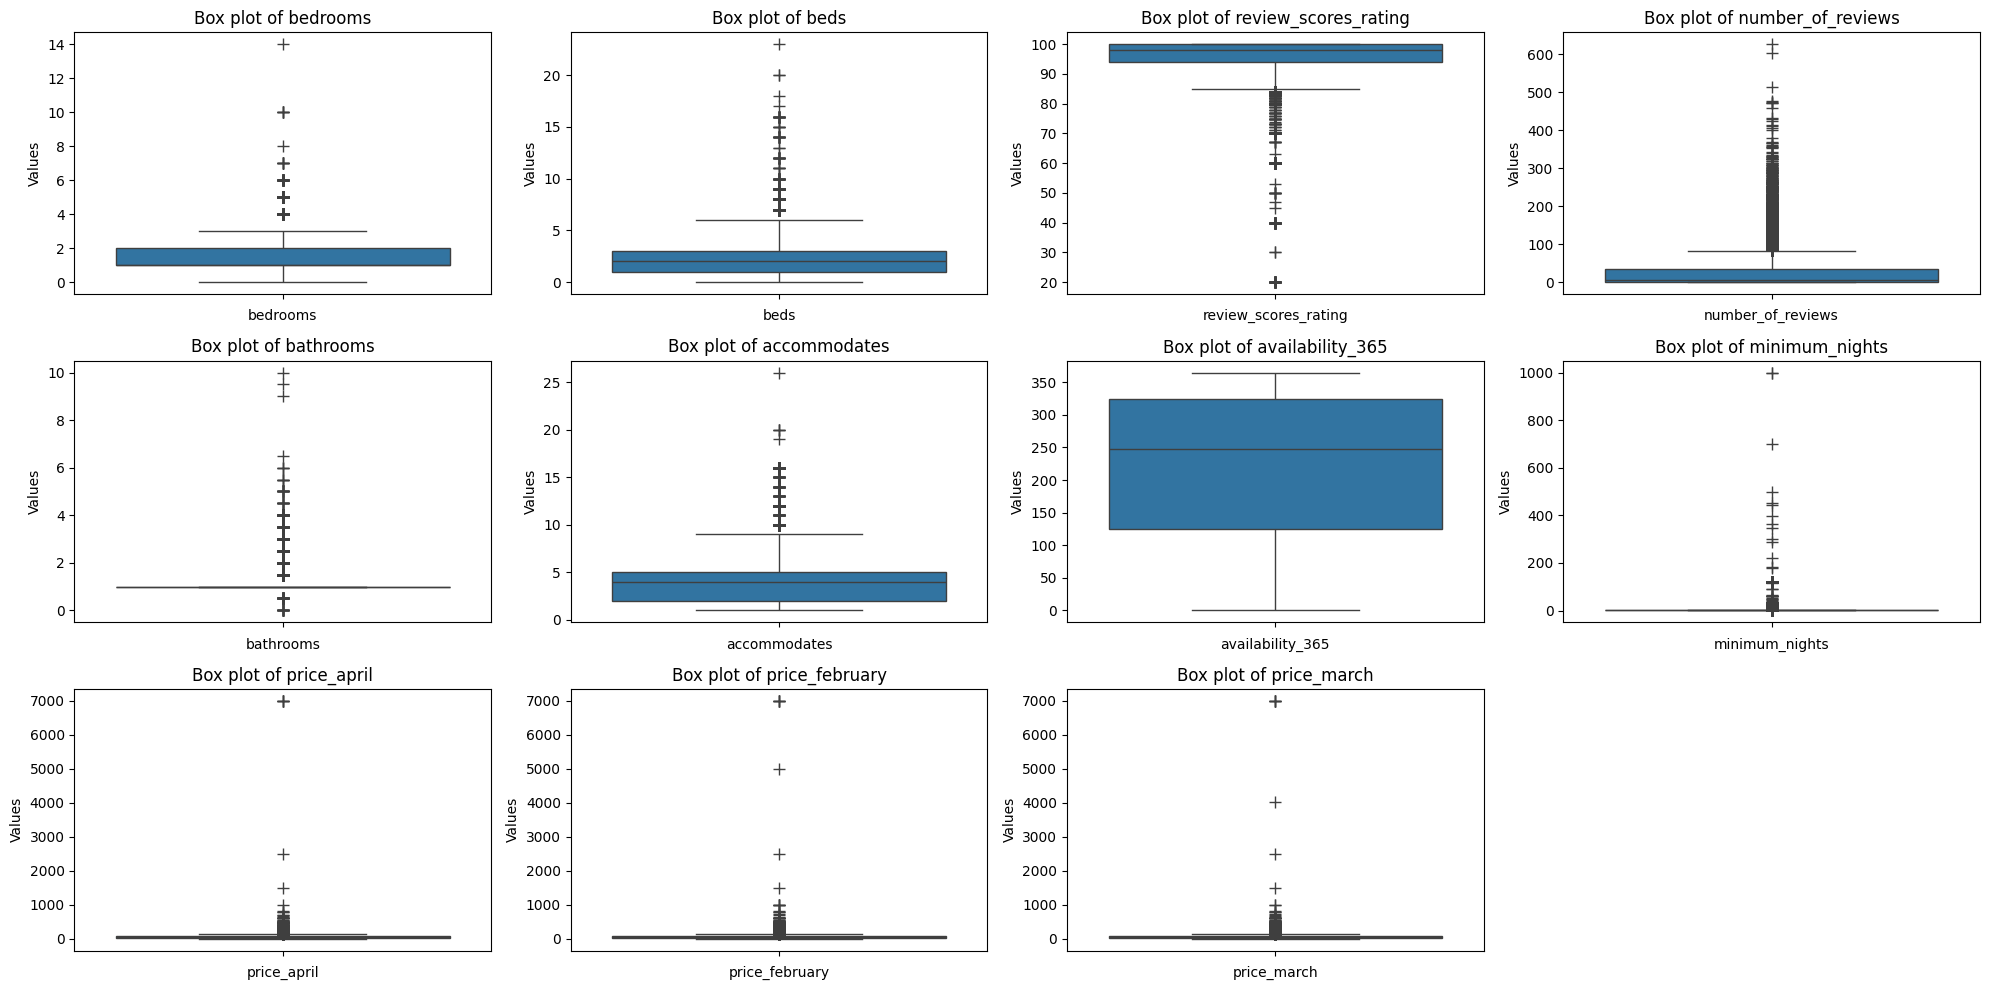

In [ ]:
numeric_columns = ['bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews',
                   'bathrooms', 'accommodates', 'availability_365', 'minimum_nights',
                   'price_april', 'price_february', 'price_march']

plt.figure(figsize=(20, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=unique_listings_2019[col], flierprops=dict(marker='+', color='red', markersize=8))
    plt.title(f'Box plot of {col}')
    plt.ylabel('Values')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**For the 2023 Dataset:**

Similarly, we examined 'number_of_reviews', 'availability_365', 'minimum_nights', and monthly prices ('price_march', 'price_june', 'price_september') for the year 2023.

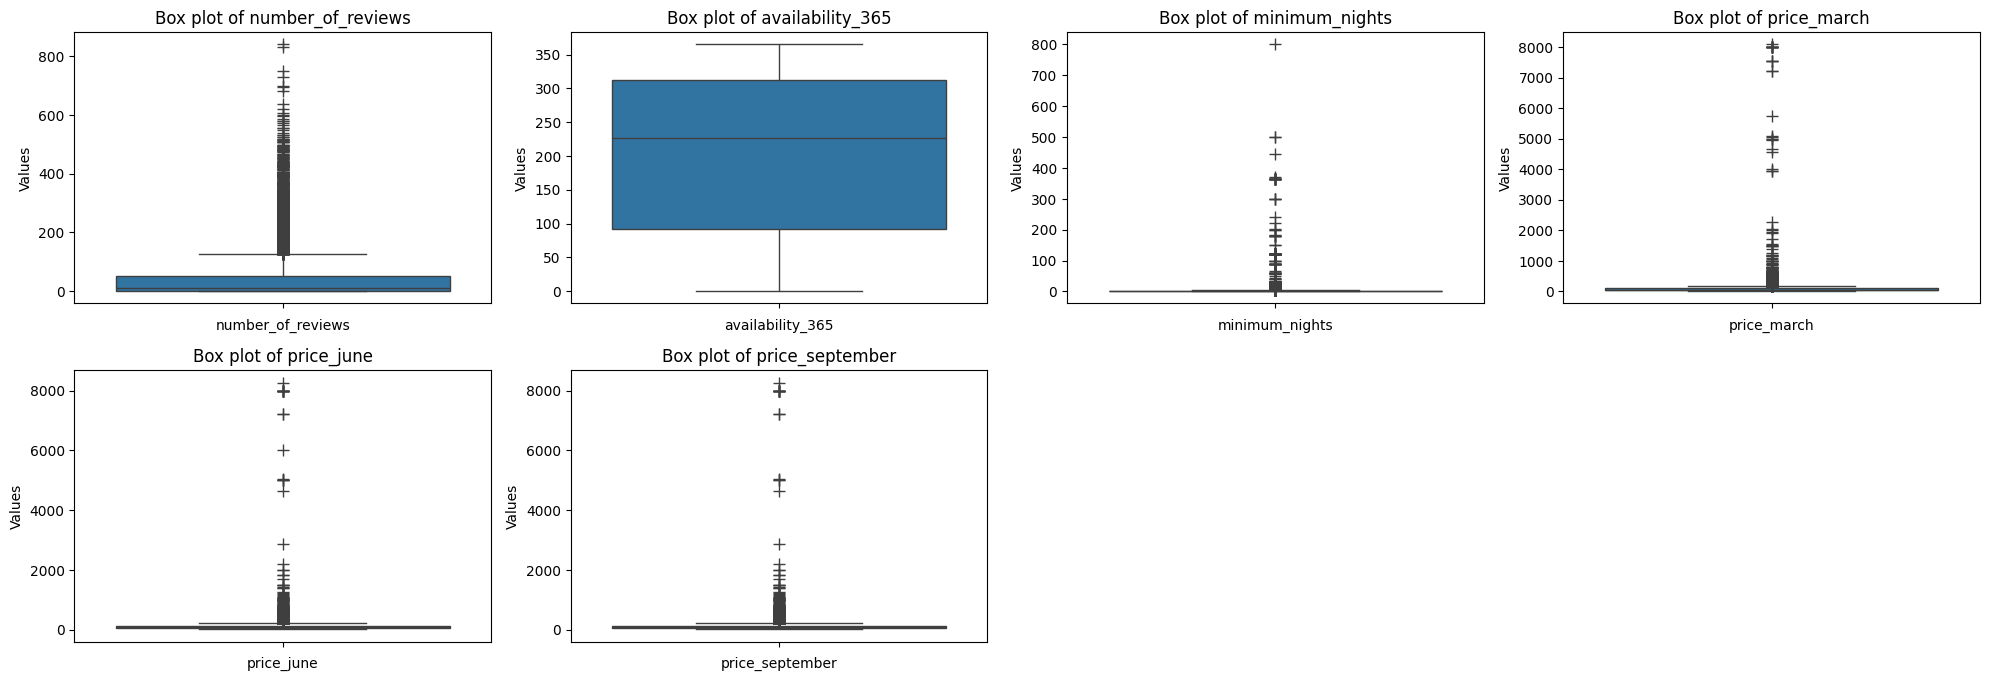

In [ ]:
numeric_columns = [ 'number_of_reviews',
                    'availability_365', 'minimum_nights',
                   'price_march', 'price_june', 'price_september']

plt.figure(figsize=(20, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=unique_listings_2023[col], flierprops=dict(marker='+', color='red', markersize=8))
    plt.title(f'Box plot of {col}')
    plt.ylabel('Values')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

###**Remove outliers**

To correct outliers in our data we used the Interquartile Range (IQR) method. This method identifies outliers by defining a "normal" data range for each column. Any values outside this range are flagged as outliers and are replaced with the median value of the respective column to ensure they do not impact our analysis.

---



Reference: https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/

In [ ]:
def replace_outliers_with_median(data, columns):
    total_outliers = 0
    total_data_points = len(data) * len(columns)

    for column in columns:
        # Calculate IQR and determine bounds
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_value = data[column].median()

        # Detect outliers
        outliers_condition = (data[column] < lower_bound) | (data[column] > upper_bound)
        outliers_count = data[outliers_condition].shape[0]
        total_outliers += outliers_count

        # Replace outliers with the median value
        data.loc[outliers_condition, column] = median_value

    # Calculate the overall percentage of outliers
    overall_outliers_percentage = (total_outliers / total_data_points) * 100
    print(f"Overall percentage of outliers in the dataset: {overall_outliers_percentage:.2f}%")

    return data

# Dictionary to hold data and columns for each year
datasets = {
    2019: {
        'data': unique_listings_2019,
        'columns': ['bedrooms', 'beds', 'review_scores_rating',
                    'bathrooms', 'accommodates', 'availability_365', 'minimum_nights'],
        'path': '/content/2019_train.csv'
    },
    2023: {
        'data': unique_listings_2023,
        'columns': ['availability_365', 'minimum_nights'],
        'path': '/content/2023_train.csv'
    }
}

for year, info in datasets.items():
    print(f"| Processing data for {year} |")
    cleaned_data = replace_outliers_with_median(info['data'], info['columns'])
    cleaned_data.to_csv(info['path'], index=False)
    print(f"Data for {year} saved to {info['path']}")

| Processing data for 2019 |
Overall percentage of outliers in the dataset: 5.46%
Data for 2019 saved to /content/2019_train.csv
| Processing data for 2023 |
Overall percentage of outliers in the dataset: 4.38%
Data for 2023 saved to /content/2023_train.csv


Initially, we used the IQR method to handle outliers in our price data. However, the IQR method set an upper bound of approximately \$128, leading to the replacement of many higher-priced listings with the median value. To preserve insights from those higher-priced listings we increased the upper bound to \$1000 to retain more of these listings in our dataset. Listings priced above this upper bound were adjusted to the median price for their respective months.


In [ ]:
# Replace prices greater than 1000 with the average price for the respective month
def replace_prices(df, month_columns):
    for month_column in month_columns:
        month_price_mean = df[month_column].mean()  # Calculate the mean price for the month
        df[month_column] = df.apply(lambda row: row[month_column] if row[month_column] <= 1000 else month_price_mean, axis=1)

# List of month columns for 2019 and 2023
month_columns_2019 = ['price_april', 'price_february', 'price_march']
month_columns_2023 = ['price_june', 'price_september', 'price_march']

replace_prices(unique_listings_2019, month_columns_2019)
replace_prices(unique_listings_2023, month_columns_2023)

## **Questions** 📊

### **Question 1.1:** Most common room type

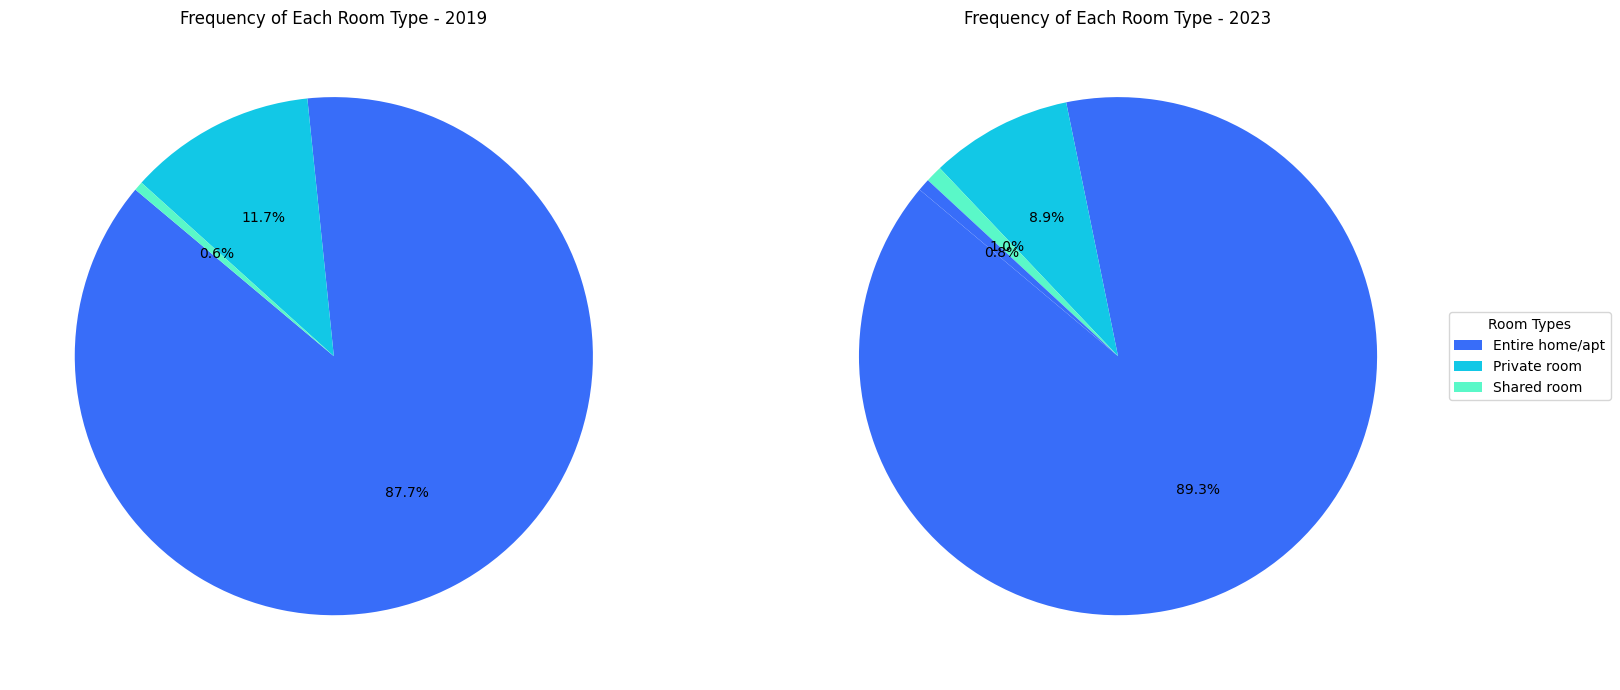

In [ ]:
# Count the occurrences of each room type
room_type_counts_2019 = unique_listings_2019['room_type'].value_counts()
room_type_counts_2023 = unique_listings_2023['room_type'].value_counts()

plt.figure(figsize=(18, 7))

colors_2019 = sns.color_palette('rainbow')[0:3]
colors_2023 = sns.color_palette('rainbow')[0:3]

# Plot for 2019 data
plt.subplot(1, 2, 1)
wedges_2019, texts_2019, autotexts_2019 = plt.pie(room_type_counts_2019, startangle=140, colors=colors_2019, autopct='%1.1f%%')
plt.title('Frequency of Each Room Type - 2019')

# Plot for 2023 data
plt.subplot(1, 2, 2)
wedges_2023, texts_2023, autotexts_2023 = plt.pie(room_type_counts_2023, startangle=140, colors=colors_2023, autopct='%1.1f%%')
plt.title('Frequency of Each Room Type - 2023')

plt.legend(wedges_2019, room_type_counts_2019.index, title="Room Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

### **Question 1.2:** Price course over the time of 3 months

/tmp/ipython-input-1093841478.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Average Price', data=data_2019, palette='deep', order=month_order_2019)
/tmp/ipython-input-1093841478.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Average Price', data=data_2023, palette='deep', order=month_order_2023)


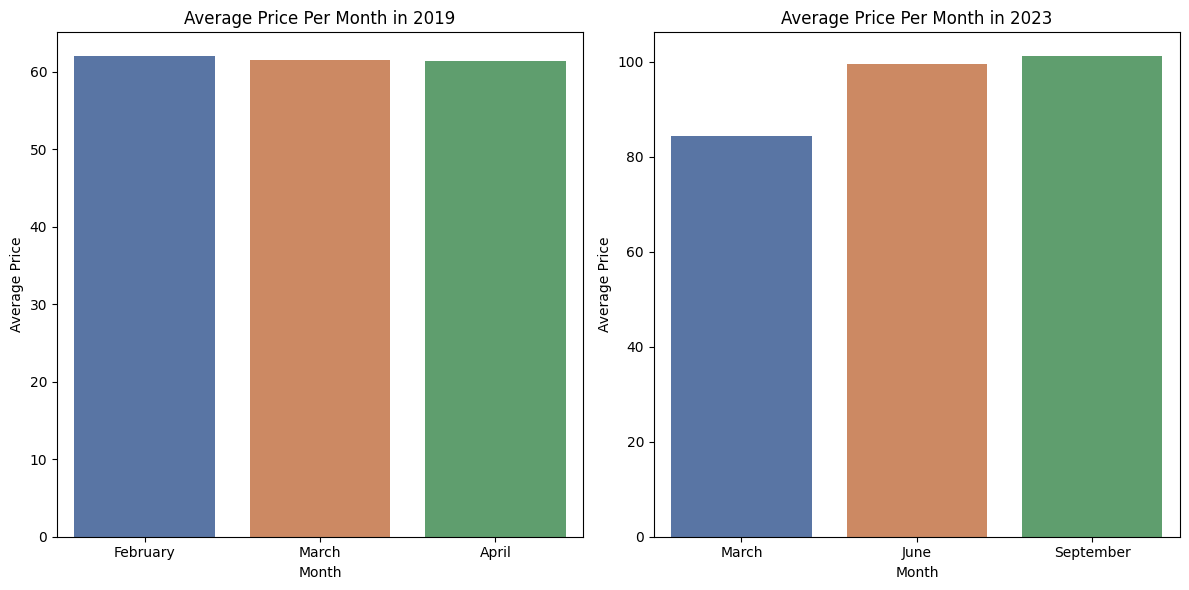

In [ ]:
data_2019 = pd.DataFrame({
    'Month': ['April', 'February', 'March'],
    'Average Price': [unique_listings_2019['price_april'].mean(),
                      unique_listings_2019['price_february'].mean(),
                      unique_listings_2019['price_march'].mean()],
    'Year': 2019
})

data_2023 = pd.DataFrame({
    'Month': ['June', 'September', 'March'],
    'Average Price': [unique_listings_2023['price_june'].mean(),
                      unique_listings_2023['price_september'].mean(),
                      unique_listings_2023['price_march'].mean()],
    'Year': 2023
})

month_order_2019 = ['February', 'March', 'April']
month_order_2023 = ['March', 'June', 'September']

# Plot
plt.figure(figsize=(12, 6))

# Plot for 2019 data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.barplot(x='Month', y='Average Price', data=data_2019, palette='deep', order=month_order_2019)
plt.title('Average Price Per Month in 2019')
plt.xlabel('Month')
plt.ylabel('Average Price')

# Plot for 2023 data
plt.subplot(1, 2, 2)
sns.barplot(x='Month', y='Average Price', data=data_2023, palette='deep', order=month_order_2023)
plt.title('Average Price Per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Average Price')

plt.tight_layout()
plt.show()

### **Question 1.3:** Top 5 Most Reviewed Neighborhoods

/tmp/ipython-input-2139181211.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_neighbourhoods_2019.index, y=top_5_neighbourhoods_2019.values, ax=ax1, palette="viridis")
/tmp/ipython-input-2139181211.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_neighbourhoods_2023.index, y=top_5_neighbourhoods_2023.values, ax=ax2, palette="viridis")


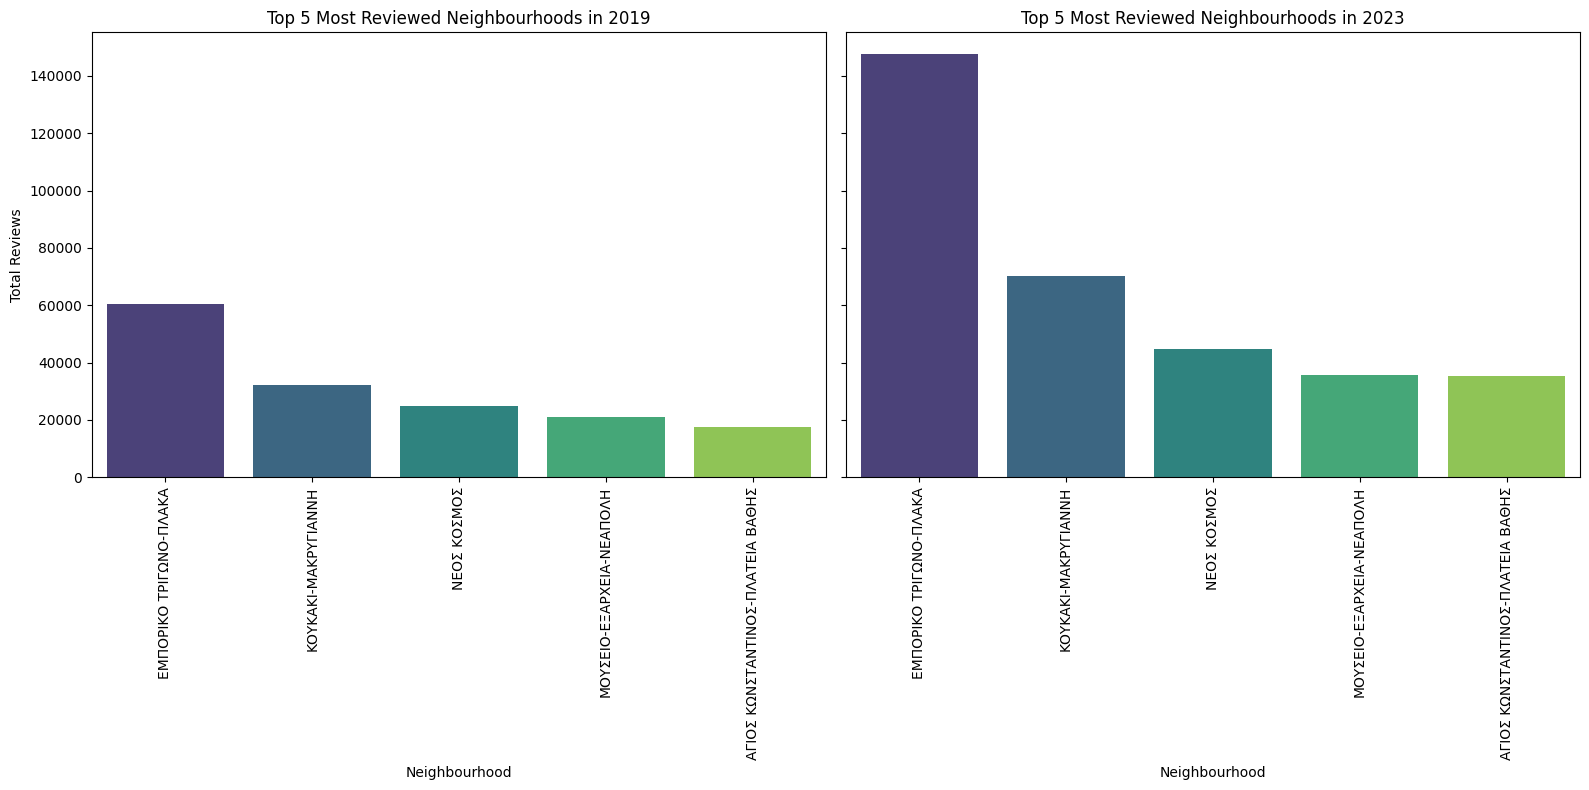

In [ ]:
# Calculate the sum of reviews per neighborhood for 2019
reviews_per_neighbourhood_2019 = unique_listings_2019.groupby('neighbourhood_cleansed')['number_of_reviews'].sum().sort_values(ascending=False)
top_5_neighbourhoods_2019 = reviews_per_neighbourhood_2019.head(5)

# Calculate the sum of reviews per neighborhood for 2023
reviews_per_neighbourhood_2023 = unique_listings_2023.groupby('neighbourhood')['number_of_reviews'].sum().sort_values(ascending=False)
top_5_neighbourhoods_2023 = reviews_per_neighbourhood_2023.head(5)

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
sns.barplot(x=top_5_neighbourhoods_2019.index, y=top_5_neighbourhoods_2019.values, ax=ax1, palette="viridis")
ax1.set_title('Top 5 Most Reviewed Neighbourhoods in 2019')
ax1.set_ylabel('Total Reviews')
ax1.set_xlabel('Neighbourhood')
ax1.tick_params(axis='x', rotation=90)

sns.barplot(x=top_5_neighbourhoods_2023.index, y=top_5_neighbourhoods_2023.values, ax=ax2, palette="viridis")
ax2.set_title('Top 5 Most Reviewed Neighbourhoods in 2023')
ax2.set_ylabel('Total Reviews')
ax2.set_xlabel('Neighbourhood')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### **Question 1.4:** Neighborhood with the most listings

/tmp/ipython-input-748517131.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=years, y=counts, palette='deep')


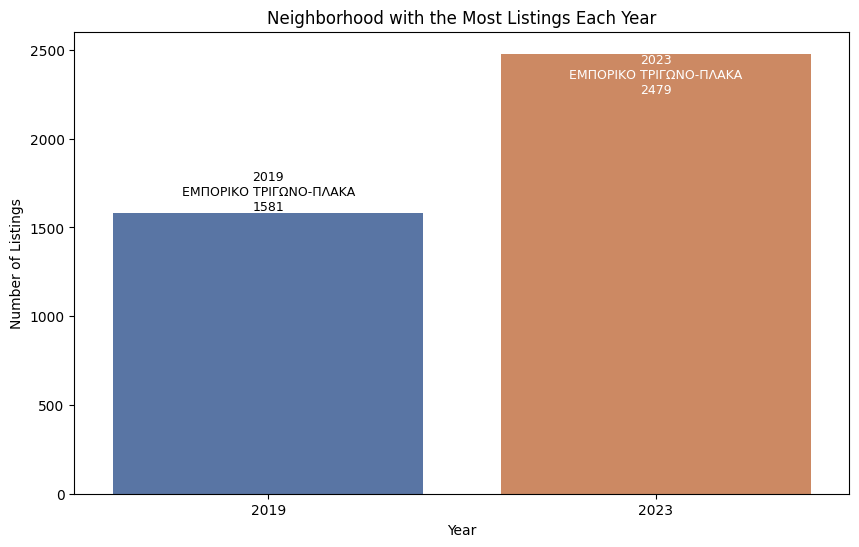

In [ ]:
# Count the occurrences of each neighborhood for 2019
neighborhood_counts_2019 = unique_listings_2019['neighbourhood_cleansed'].value_counts()
most_listed_neighborhood_2019 = neighborhood_counts_2019.idxmax()
most_listings_count_2019 = neighborhood_counts_2019.max()

# Count the occurrences of each neighborhood for 2023
neighborhood_counts_2023 = unique_listings_2023['neighbourhood'].value_counts()
most_listed_neighborhood_2023 = neighborhood_counts_2023.idxmax()
most_listings_count_2023 = neighborhood_counts_2023.max()

# Data for plotting
years = ['2019', '2023']
counts = [most_listings_count_2019, most_listings_count_2023]
neighborhoods = [most_listed_neighborhood_2019, most_listed_neighborhood_2023]

# Plot
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=years, y=counts, palette='deep')
plt.title('Neighborhood with the Most Listings Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Listings')

for i, bar in enumerate(bars.patches):
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2
    plt.text(x_value, y_value, f'{years[i]}\n{neighborhoods[i]}\n{counts[i]}',
             ha='center', va='top' if y_value > 2000 else 'bottom',
             color='white' if y_value > 2000 else 'black', fontsize=9)

plt.show()

### **Question 1.5:** Number of listings per neighborhood and per month

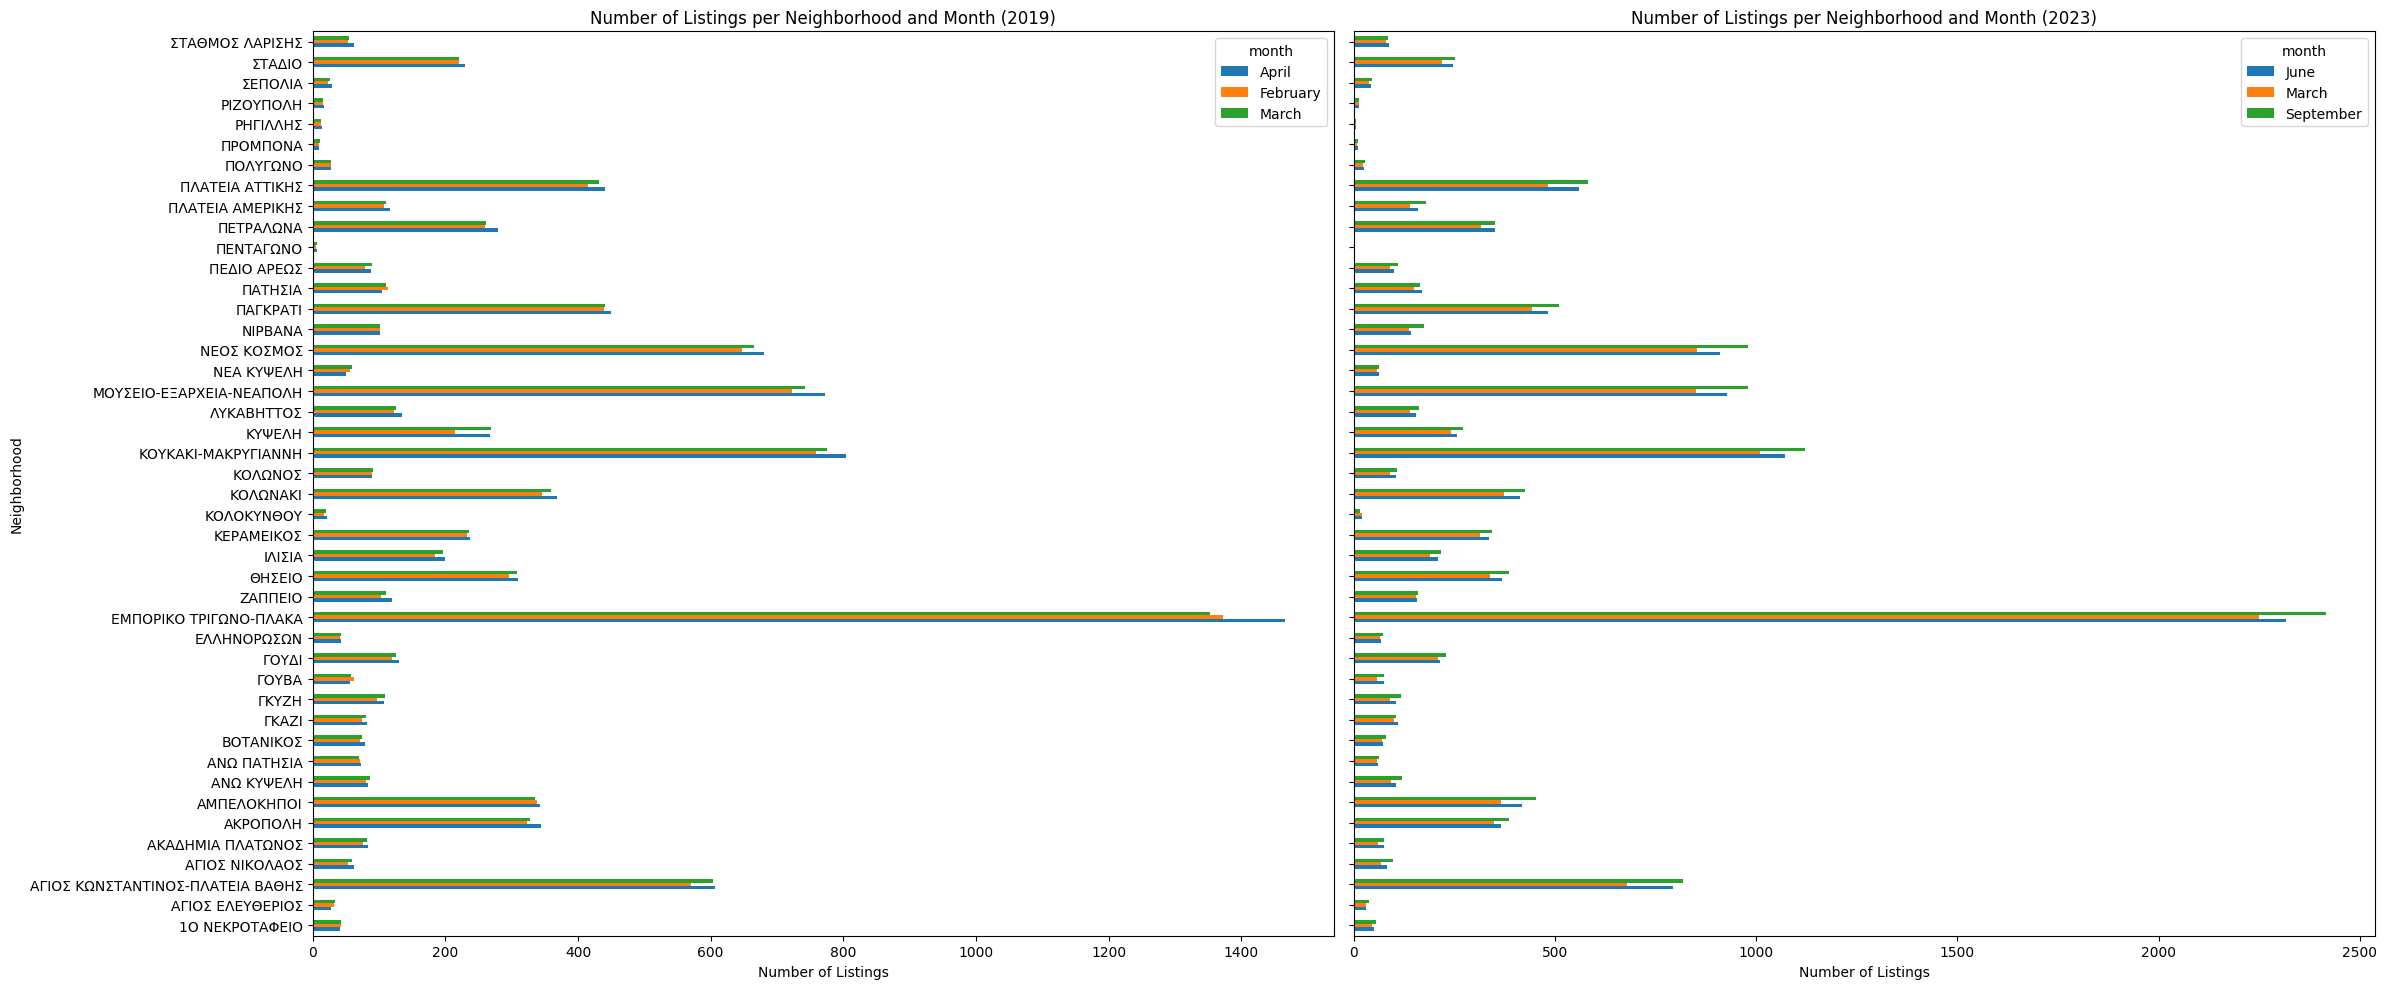

In [ ]:
# Function to load and preprocess the data
def load_and_preprocess_data(paths, year):
    monthly_data = []
    for month, file_paths in paths.items():
        df_list = [pd.read_csv(file, low_memory=False) for file in file_paths]
        df = pd.concat(df_list, axis=0)  # Combine data from multiple files per month
        df['month'] = month  # Add month column
        monthly_data.append(df)

    # Combine all data into a single DataFrame
    all_data = pd.concat(monthly_data, ignore_index=True)
    return all_data

# Paths to the CSV files for each year
paths_2019 = {
    'April': ['/content/drive/My Drive/Datasets/data/2019/april/listings.csv'],
    'February': ['/content/drive/My Drive/Datasets/data/2019/febrouary/listings.csv'],
    'March': ['/content/drive/My Drive/Datasets/data/2019/march/listings.csv']
}

paths_2023 = {
    'June': ['/content/drive/My Drive/Datasets/data/2023/june/listings0.csv',
             '/content/drive/My Drive/Datasets/data/2023/june/listings.csv'],
    'September': ['/content/drive/My Drive/Datasets/data/2023/september/listings0.csv',
                   '/content/drive/My Drive/Datasets/data/2023/september/listings.csv'],
    'March': ['/content/drive/My Drive/Datasets/data/2023/march/listings0.csv',
              '/content/drive/My Drive/Datasets/data/2023/march/listings.csv']
}

# Load and process data for each year
data_2019 = load_and_preprocess_data(paths_2019, 2019)
data_2023 = load_and_preprocess_data(paths_2023, 2023)

# Function to count listings by neighborhood and month
def count_listings(data):
    grouped = data.groupby(['neighbourhood_cleansed', 'month']).size().unstack(fill_value=0)
    return grouped

# Count listings for each year
grouped_2019 = count_listings(data_2019)
grouped_2023 = count_listings(data_2023)

# Plot the data for both years side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), sharey=True)

# Plot 2019 data
grouped_2019.plot(kind='barh', ax=axes[0])
axes[0].set_title('Number of Listings per Neighborhood and Month (2019)')
axes[0].set_xlabel('Number of Listings')
axes[0].set_ylabel('Neighborhood')

# Plot 2023 data
grouped_2023.plot(kind='barh', ax=axes[1])
axes[1].set_title('Number of Listings per Neighborhood and Month (2023)')
axes[1].set_xlabel('Number of Listings')

plt.tight_layout()
plt.show()

###**Question 1.6:** Histogram of the neighborhood variable

/tmp/ipython-input-581557375.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-581557375.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


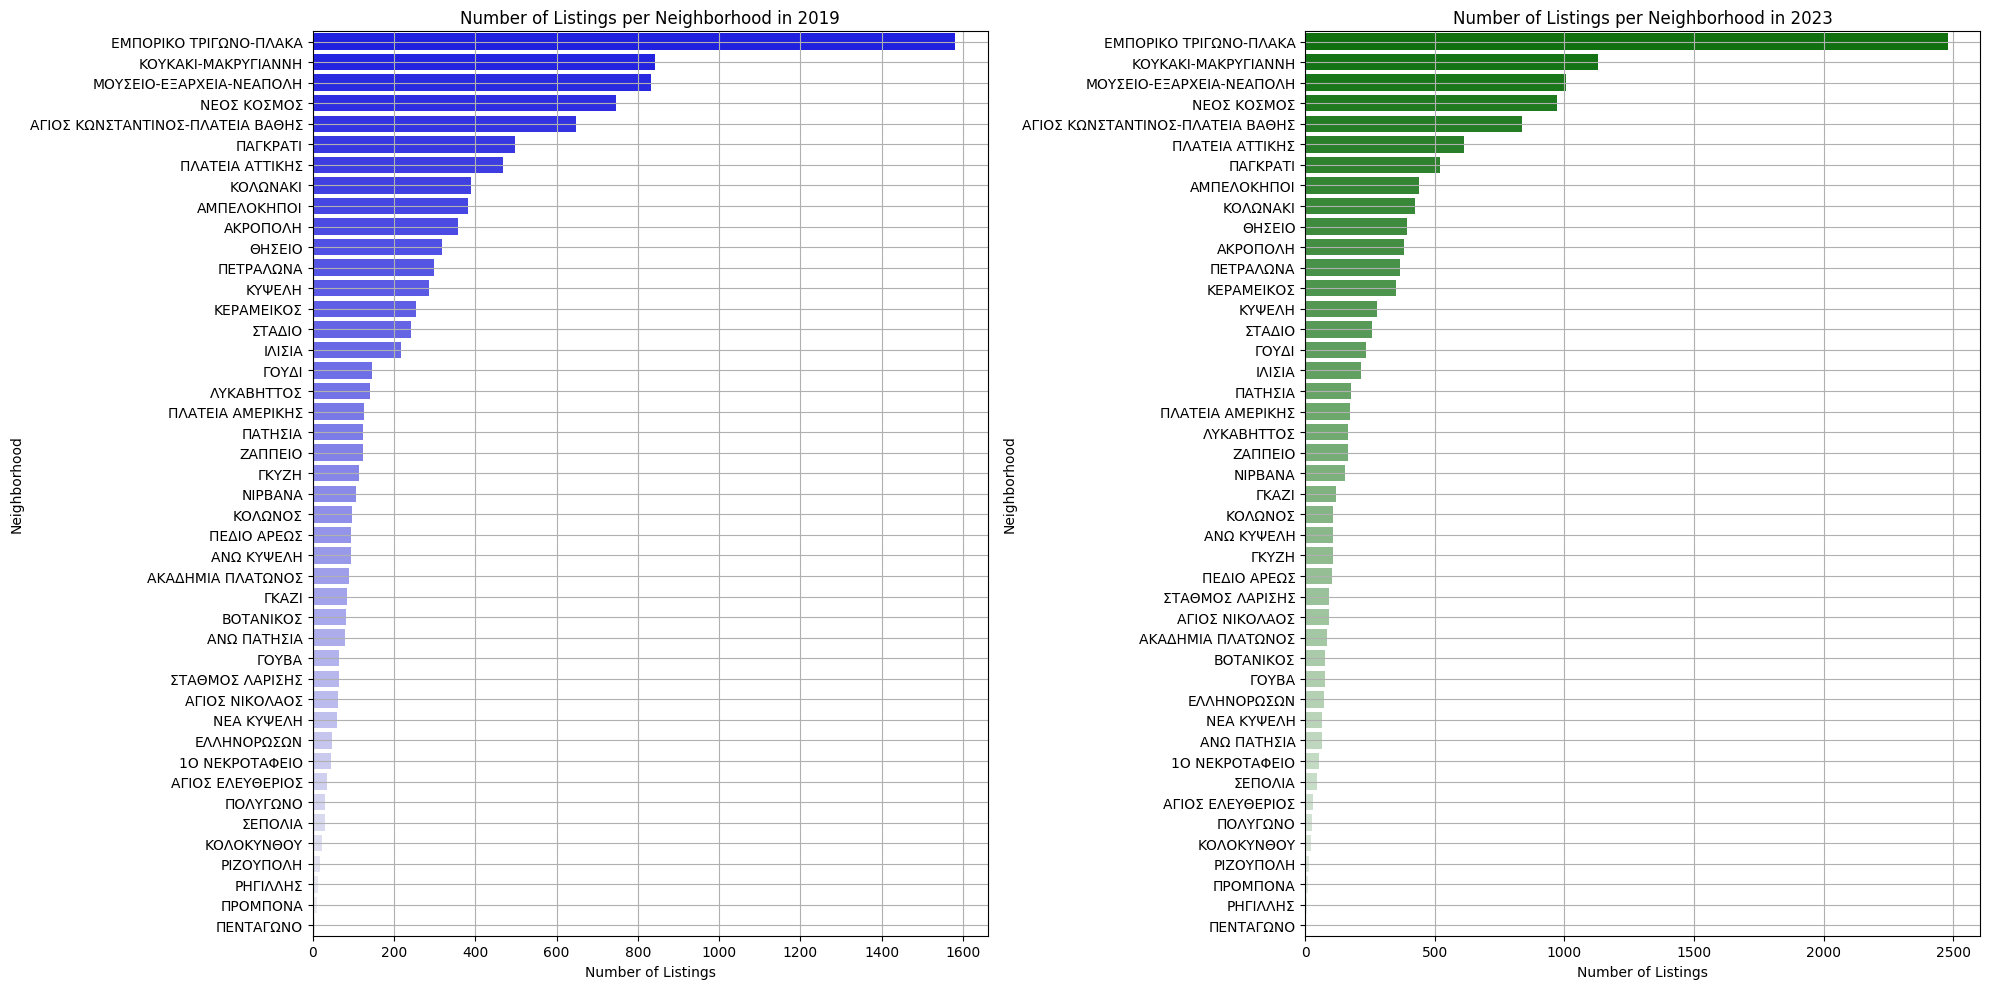

In [ ]:
# Aggregate the data by 'neighbourhood_cleansed' to count unique listings
neighborhood_listings_2019 = unique_listings_2019.groupby('neighbourhood_cleansed')['id'].nunique().reset_index(name='Listings')
neighborhood_listings_2023 = unique_listings_2023.groupby('neighbourhood')['id'].nunique().reset_index(name='Listings')

# Sort the results by the number of listings
neighborhood_listings_2019_sorted = neighborhood_listings_2019.sort_values('Listings', ascending=False)
neighborhood_listings_2023_sorted = neighborhood_listings_2023.sort_values('Listings', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

blue_palette = sns.light_palette("blue", len(neighborhood_listings_2019_sorted), reverse=True)
green_palette = sns.light_palette("green", len(neighborhood_listings_2023_sorted), reverse=True)

# Plot for 2019
sns.barplot(
    x='Listings',
    y='neighbourhood_cleansed',
    data=neighborhood_listings_2019_sorted,
    ax=ax[0],
    palette=blue_palette
)
ax[0].set_title('Number of Listings per Neighborhood in 2019')
ax[0].set_xlabel('Number of Listings')
ax[0].set_ylabel('Neighborhood')
ax[0].grid(True)

# Plot for 2023
sns.barplot(
    x='Listings',
    y='neighbourhood',
    data=neighborhood_listings_2023_sorted,
    ax=ax[1],
    palette=green_palette
)
ax[1].set_title('Number of Listings per Neighborhood in 2023')
ax[1].set_xlabel('Number of Listings')
ax[1].set_ylabel('Neighborhood')
ax[1].grid(True)

plt.tight_layout()
plt.show()

### **Question 1.7:** Most common room type in each neighborhood

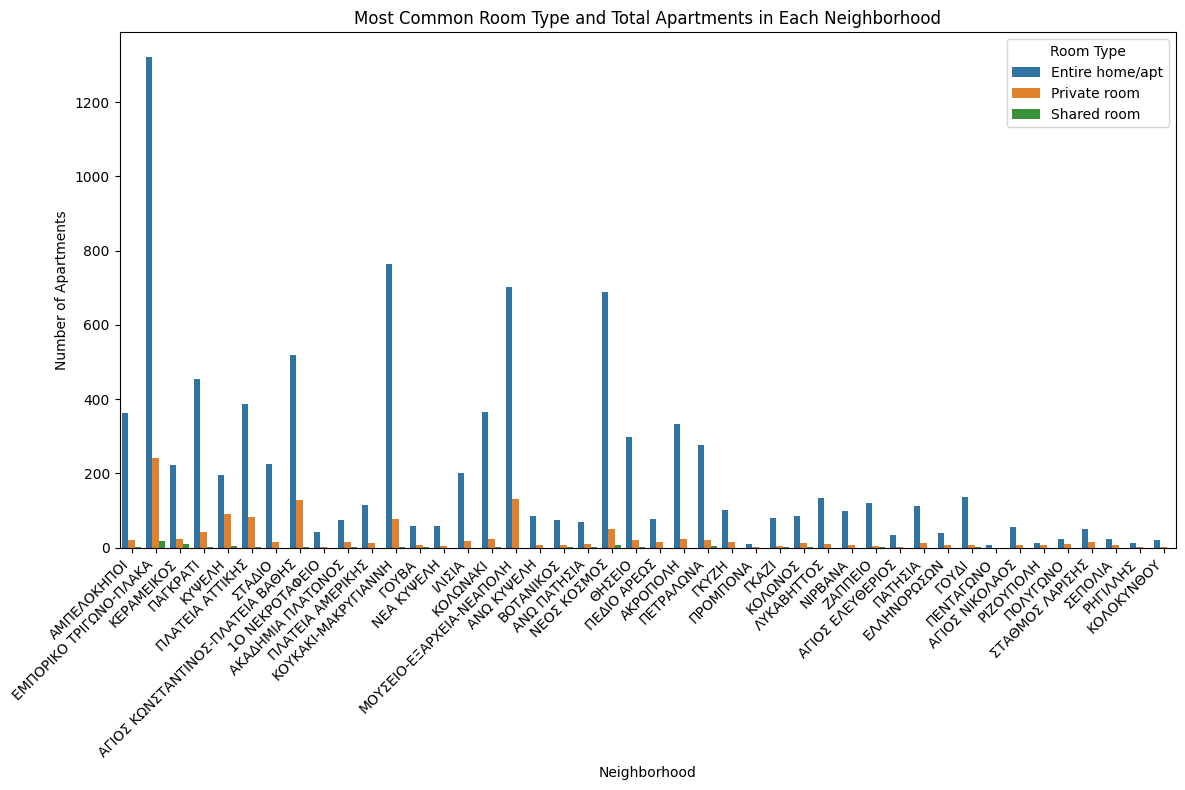

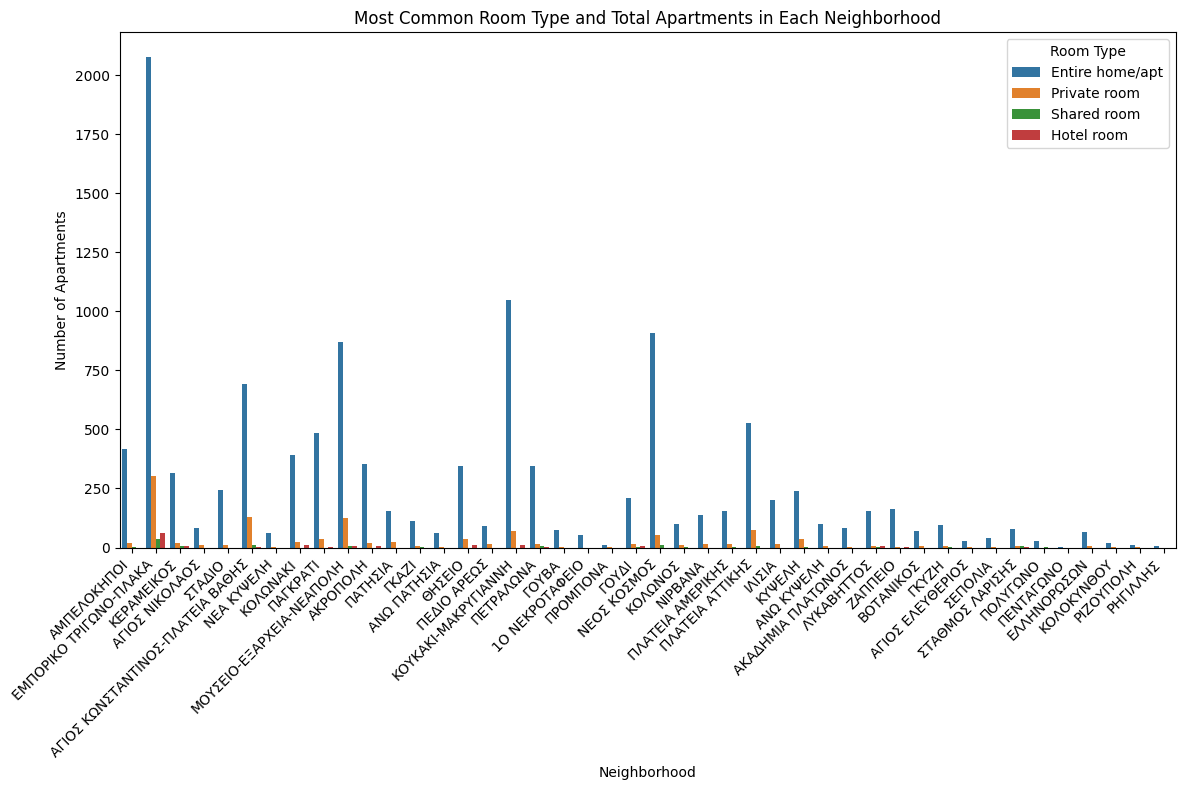

In [ ]:
import seaborn as sns


# Calculate the total number of apartments in each neighborhood
neighborhood_counts = unique_listings_2019['neighbourhood_cleansed'].value_counts()

plt.figure(figsize=(12, 8))
sns.countplot(data=unique_listings_2019, x='neighbourhood_cleansed', hue='room_type')
plt.title('Most Common Room Type and Total Apartments in Each Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Apartments')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Room Type', loc='upper right')
plt.tight_layout()

plt.show()

neighborhood_counts = unique_listings_2023['neighbourhood'].value_counts()

plt.figure(figsize=(12, 8))
sns.countplot(data=unique_listings_2023, x='neighbourhood', hue='room_type')
plt.title('Most Common Room Type and Total Apartments in Each Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Apartments')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Room Type', loc='upper right')
plt.tight_layout()

plt.show()


### **Question 1.8:** Most expensive room type


In February, the most expensive room type is 'Entire home/apt' with a maximum price of $1000.00.
In March, the most expensive room type is 'Entire home/apt' with a maximum price of $1000.00.
In April, the most expensive room type is 'Entire home/apt' with a maximum price of $1000.00.


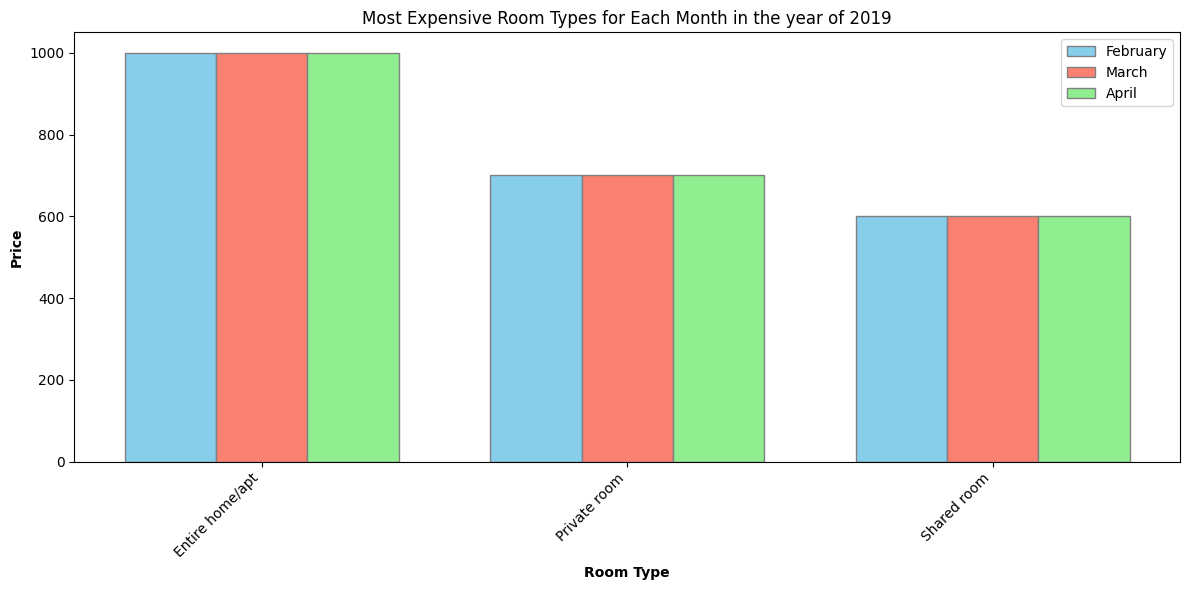

In [ ]:
# Calculate maximum price for each room type in February, March, and April
max_prices_february = unique_listings_2019.groupby('room_type')['price_february'].max()
max_prices_march = unique_listings_2019.groupby('room_type')['price_march'].max()
max_prices_april = unique_listings_2019.groupby('room_type')['price_april'].max()

# Find the room type with the highest maximum price for each month
most_expensive_room_type_february = max_prices_february.idxmax()
most_expensive_room_type_march = max_prices_march.idxmax()
most_expensive_room_type_april = max_prices_april.idxmax()

# Get the corresponding maximum prices
highest_price_february = max_prices_february.max()
highest_price_march = max_prices_march.max()
highest_price_april = max_prices_april.max()

print(f"In February, the most expensive room type is '{most_expensive_room_type_february}' with a maximum price of ${highest_price_february:.2f}.")
print(f"In March, the most expensive room type is '{most_expensive_room_type_march}' with a maximum price of ${highest_price_march:.2f}.")
print(f"In April, the most expensive room type is '{most_expensive_room_type_april}' with a maximum price of ${highest_price_april:.2f}.")

# Combine maximum prices for all months into a single DataFrame
max_prices = pd.DataFrame({
    'February': max_prices_february,
    'March': max_prices_march,
    'April': max_prices_april
})

# Get room types
room_types = max_prices.index

# Set width of bars
bar_width = 0.25

# Set position of bars on x-axis
r1 = np.arange(len(room_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(r1, max_prices['February'], color='skyblue', width=bar_width, edgecolor='grey', label='February')
plt.bar(r2, max_prices['March'], color='salmon', width=bar_width, edgecolor='grey', label='March')
plt.bar(r3, max_prices['April'], color='lightgreen', width=bar_width, edgecolor='grey', label='April')

# Add xticks on the middle of the group bars
plt.xlabel('Room Type', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(room_types))], room_types, rotation=45, ha='right')

# Create legend & Show plot
plt.legend()
plt.title('Most Expensive Room Types for Each Month in the year of 2019')
plt.tight_layout()
plt.show()


In February, the most expensive room type is 'Entire home/apt' with a maximum price of $1000.00.
In March, the most expensive room type is 'Entire home/apt' with a maximum price of $1000.00.
In April, the most expensive room type is 'Entire home/apt' with a maximum price of $1000.00.


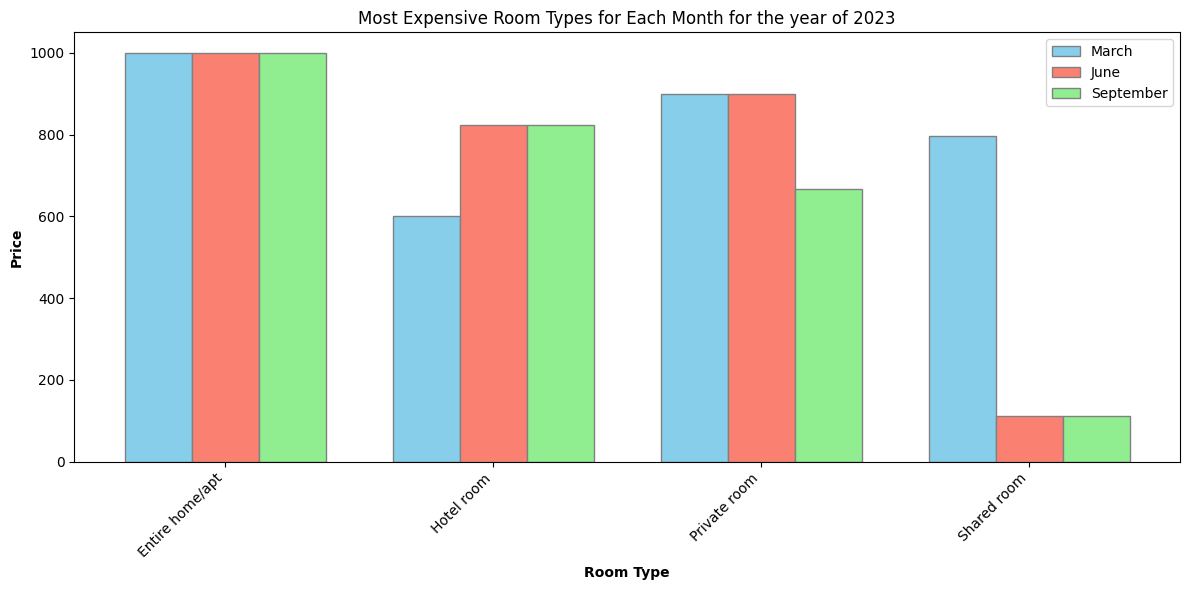

In [ ]:
# Calculate maximum price for each room type in February, March, and April
max_prices_february = unique_listings_2023.groupby('room_type')['price_march'].max()
max_prices_march = unique_listings_2023.groupby('room_type')['price_june'].max()
max_prices_april = unique_listings_2023.groupby('room_type')['price_september'].max()

# Find the room type with the highest maximum price for each month
most_expensive_room_type_february = max_prices_february.idxmax()
most_expensive_room_type_march = max_prices_march.idxmax()
most_expensive_room_type_april = max_prices_april.idxmax()

# Get the corresponding maximum prices
highest_price_february = max_prices_february.max()
highest_price_march = max_prices_march.max()
highest_price_april = max_prices_april.max()

print(f"In February, the most expensive room type is '{most_expensive_room_type_february}' with a maximum price of ${highest_price_february:.2f}.")
print(f"In March, the most expensive room type is '{most_expensive_room_type_march}' with a maximum price of ${highest_price_march:.2f}.")
print(f"In April, the most expensive room type is '{most_expensive_room_type_april}' with a maximum price of ${highest_price_april:.2f}.")

# Combine maximum prices for all months into a single DataFrame
max_prices = pd.DataFrame({
    'February': max_prices_february,
    'March': max_prices_march,
    'April': max_prices_april
})

# Get room types
room_types = max_prices.index

bar_width = 0.25

# Set position of bars on x-axis
r1 = np.arange(len(room_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(r1, max_prices['February'], color='skyblue', width=bar_width, edgecolor='grey', label='March')
plt.bar(r2, max_prices['March'], color='salmon', width=bar_width, edgecolor='grey', label='June')
plt.bar(r3, max_prices['April'], color='lightgreen', width=bar_width, edgecolor='grey', label='September')

plt.xlabel('Room Type', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(room_types))], room_types, rotation=45, ha='right')

plt.legend()
plt.title('Most Expensive Room Types for Each Month for the year of 2023')
plt.tight_layout()
plt.show()

### **Question 1.9:** Display the listings for the month of April on the map

In [ ]:
import folium

# Create map
athens_coords = [37.9838, 23.7275]  # Athens coordinates
map_april_athens = folium.Map(location=athens_coords, zoom_start=12)

# Add marker for each listing in Athens
for index, row in unique_listings_2019.iterrows():
    if row['price_april'] > 0 and row['city'] == 'Athens':  # Check if the value is positive and belongs in Athens
        popup_html = f"<b>Bed Type:</b> {row['bed_type']}<br>" \
                     f"<b>Room Type:</b> {row['room_type']}<br>" \
                     f"<b>Transit:</b> {row['transit']}<br>"
        popup = folium.Popup(popup_html, max_width=300)
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=popup,
                      icon=folium.Icon(color='blue')).add_to(map_april_athens)

# Show map
map_april_athens

### **Question 1.10:** Worldclouds of neighbourhood, transit, room_type, description and last_review

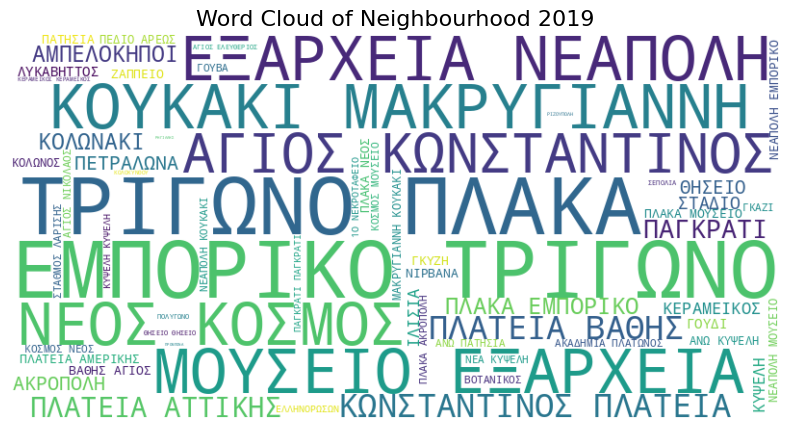

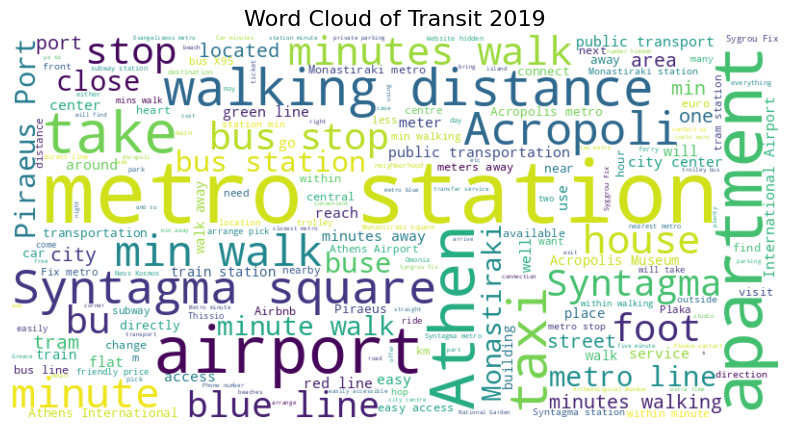

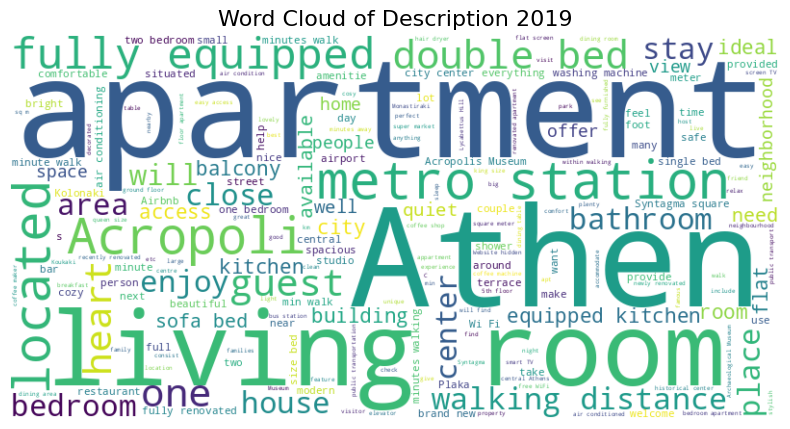

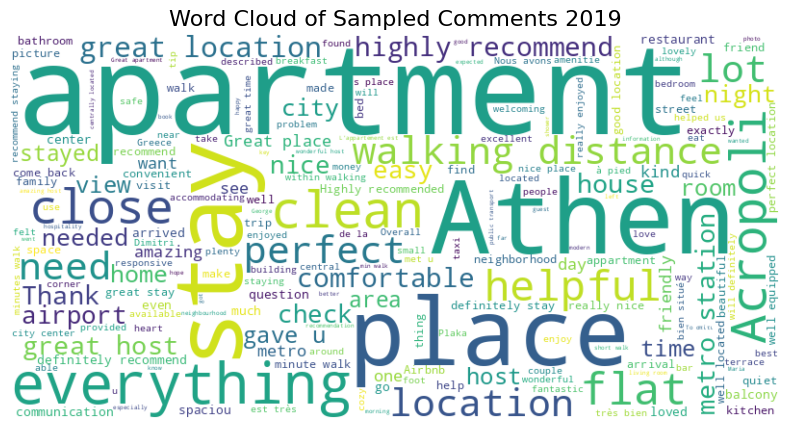

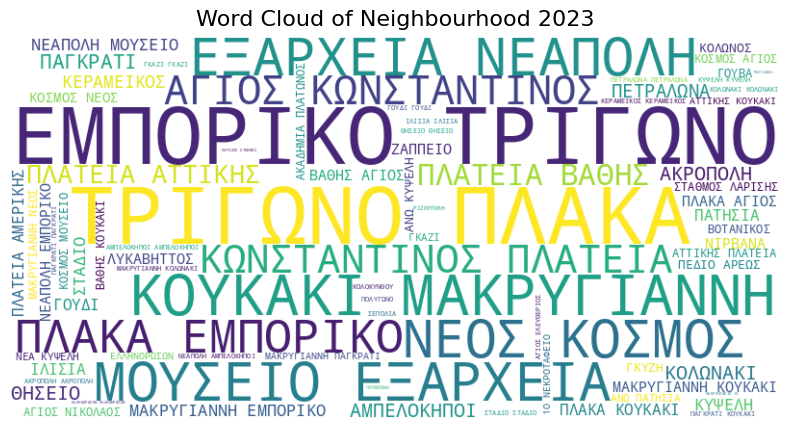

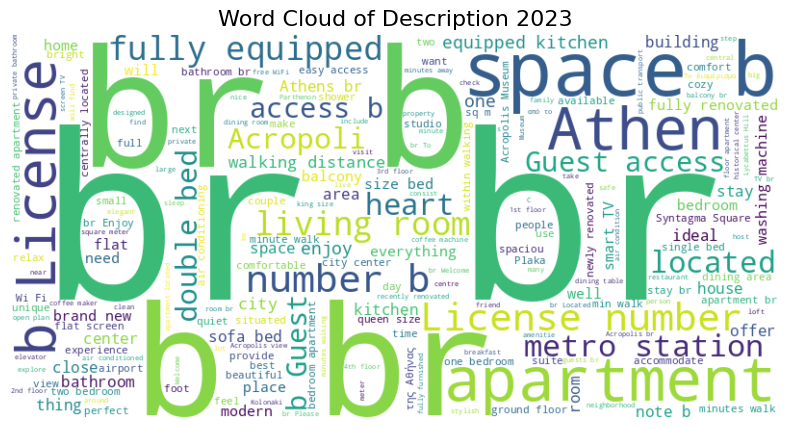

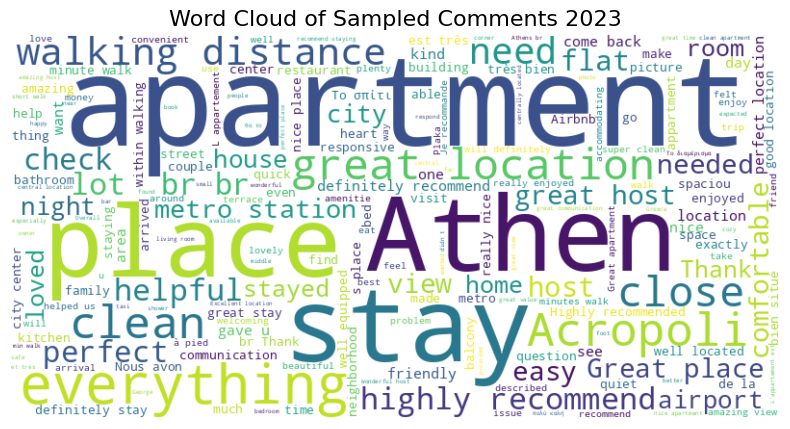

In [ ]:
from wordcloud import WordCloud

# Define a function to generate word clouds with titles
def generate_wordcloud_with_title(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)  # Set title
    plt.show()

# Generate word cloud for 'neighbourhood_cleansed'
neighbourhood_text = ' '.join(unique_listings_2019['neighbourhood_cleansed'].dropna())
generate_wordcloud_with_title(neighbourhood_text, 'Word Cloud of Neighbourhood 2019')

# Generate word cloud for 'transit'
transit_text = ' '.join(unique_listings_2019['transit'].dropna())
generate_wordcloud_with_title(transit_text, 'Word Cloud of Transit 2019')

# Generate word cloud for 'description'
description_text = ' '.join(unique_listings_2019['description'].dropna())
generate_wordcloud_with_title(description_text, 'Word Cloud of Description 2019')

# Paths to the CSV files for each month
review_april_path = '/content/drive/My Drive/Datasets/data/2019/april/reviews.csv'
review_february_path = '/content/drive/My Drive/Datasets/data/2019/febrouary/reviews.csv'
review_march_path = '/content/drive/My Drive/Datasets/data/2019/march/reviews.csv'

# Read and concatenate the comments from all CSV files
comments_df = pd.concat([
    pd.read_csv(review_april_path)['comments'],
    pd.read_csv(review_february_path)['comments'],
    pd.read_csv(review_march_path)['comments']
], ignore_index=True)

# Randomly sample 60% of the comments
sampled_comments = comments_df.dropna().sample(frac=0.6, random_state=42).astype(str)

# Concatenate all sampled comments into a single string
all_comments_text = ' '.join(sampled_comments)

# Generate word cloud for the sampled comments
generate_wordcloud_with_title(all_comments_text, 'Word Cloud of Sampled Comments 2019')

# ---------------------------------------------------------------------------------- #
# Generate word cloud for 'neighbourhood_cleansed'
neighbourhood_text = ' '.join(unique_listings_2023['neighbourhood_cleansed'].dropna())
generate_wordcloud_with_title(neighbourhood_text, 'Word Cloud of Neighbourhood 2023')


# Generate word cloud for 'description'
description_text = ' '.join(unique_listings_2023['description'].dropna())
generate_wordcloud_with_title(description_text, 'Word Cloud of Description 2023')

# Paths to the CSV files for each month ---- !!! variable name wrong !!! ----
review_april_path = '/content/drive/My Drive/Datasets/data/2023/march/reviews.csv'
review_february_path = '/content/drive/My Drive/Datasets/data/2023/june/reviews.csv'
review_march_path = '/content/drive/My Drive/Datasets/data/2023/september/reviews.csv'

# Read and concatenate the comments from all CSV files
comments_df = pd.concat([
    pd.read_csv(review_april_path)['comments'],
    pd.read_csv(review_february_path)['comments'],
    pd.read_csv(review_march_path)['comments']
], ignore_index=True)

# Randomly sample 60% of the comments
sampled_comments = comments_df.dropna().sample(frac=0.6, random_state=42).astype(str)

# Concatenate all sampled comments into a single string
all_comments_text = ' '.join(sampled_comments)

# Generate word cloud for the sampled comments
generate_wordcloud_with_title(all_comments_text, 'Word Cloud of Sampled Comments 2023')

### **Question 1.11:** Amenities

First we display all of the unique words in the amenities column to determine how to group them.

In [ ]:
# Function to process and count amenities
def count_amenities(amenities_series):
    amenities_counter = Counter()
    # Regular expression to find words within curly braces or square brackets
    pattern = re.compile(r'(?<=[\{\[])(.*?)(?=[\}\]])')

    for amenities_list in amenities_series:
        if pd.isna(amenities_list):
            continue  # Skip processing if the entry is NaN
        # Find the substring that contains the amenities (removing outer braces/brackets)
        found = pattern.search(amenities_list)
        if found:
            # Split amenities on commas and strip extra spaces and quotes
            amenities = found.group(0).split(',')
            # Clean up the amenities by removing leading/trailing spaces and extra quotes
            cleaned_amenities = [amenity.strip().replace('"', '').replace("'", "").lower() for amenity in amenities]
            # Update the counter with the list of amenities
            amenities_counter.update(cleaned_amenities)

    return amenities_counter

amenities_counts_2019 = count_amenities(unique_listings_2019['amenities'])
amenities_counts_2023 = count_amenities(unique_listings_2023['amenities'])

print("Amenities Counts 2019:")
print(amenities_counts_2019)
print("\nAmenities Counts 2023:")
print(amenities_counts_2023)

Amenities Counts 2019:
Counter({'wifi': 9766, 'essentials': 9735, 'kitchen': 9486, 'air conditioning': 9294, 'hangers': 9251, 'hair dryer': 8995, 'shampoo': 8743, 'heating': 8650, 'tv': 8519, 'iron': 8342, 'laptop friendly workspace': 7114, 'elevator': 6987, 'washer': 6860, 'hot water': 6583, 'refrigerator': 5439, 'dishes and silverware': 5021, 'first aid kit': 5000, 'cooking basics': 4984, 'fire extinguisher': 4730, 'coffee maker': 4714, 'bed linens': 4655, 'step-free access': 4617, 'family/kid friendly': 4397, 'oven': 4146, 'long term stays allowed': 4139, 'free street parking': 3901, 'host greets you': 3853, 'stove': 3466, 'patio or balcony': 3368, 'lock on bedroom door': 3159, 'extra pillows and blankets': 3085, 'smoke detector': 2658, 'microwave': 2641, 'wide doorway': 2500, 'private entrance': 2480, 'luggage dropoff allowed': 2455, 'paid parking off premises': 2187, 'smoking allowed': 2185, 'internet': 2136, 'carbon monoxide detector': 1756, 'pets allowed': 1752, 'self check-in':






Next, we categorize the listed amenities into specific groups and update each listing's amenities with these categories. This reorganized data is then stored in the 'amenities' columns of our 2019 and 2023 datasets.







In [ ]:
from collections import defaultdict

# Define categories for amenities
categories = {
    "Technology & Entertainment": ["tv", "cable tv", "internet", "wifi", "netflix", "smart tv", "dvd player", "game console", "fax machine", "printer", "amazon echo", "projector and screen"],
    "Comfort & Convenience": ["air conditioning", "heating", "elevator", "essentials", "shampoo", "hair dryer", "iron", "hangers", "bed linens", "extra pillows and blankets", "room-darkening shades", "breakfast", "24-hour check-in"],
    "Kitchen & Dining": ["kitchen", "microwave", "coffee maker", "refrigerator", "dishwasher", "dishes and silverware", "cooking basics", "oven", "stove", "full kitchen", "mini fridge", "espresso machine", "formal dining area", "breakfast table", "wine cooler", "convection oven", "double oven", "dining area", "mudroom"],
    "Health & Safety": ["first aid kit", "safety card", "fire extinguisher", "smoke detector", "carbon monoxide detector", "handheld shower head", "lock on bedroom door", "fixed grab bars for shower", "fixed grab bars for toilet", "shower chair", "roll-in shower", "bathtub with bath chair"],
    "Accessibility & Parking": ["step-free access", "wide doorway", "wide hallway clearance", "flat path to front door", "wide entryway", "accessible-height bed", "accessible-height toilet", "wheelchair accessible", "disabled parking spot", "ground floor access"],
    "Family Features": ["family/kid friendly", "high chair", "pack ’n play/travel crib", "baby monitor", "changing table", "baby bath", "children’s books and toys", "crib", "children’s dinnerware", "stair gates", "outlet covers", "window guards", "table corner guards", "fireplace guards"],
    "Outdoor & Leisure": ["patio or balcony", "bbq grill", "garden or backyard", "beach essentials", "pool", "private pool", "sun loungers", "hammock", "beach view", "beachfront", "mountain view", "waterfront", "terrace", "balcony", "ski-in/ski-out", "fire pit"],
    "Personal Care & Hygiene": ["hot water", "luggage dropoff allowed", "essentials", "body soap", "bath towel", "toilet paper", "bidet", "heated towel rack", "hair dryer"],
    "Pet Friendly": ["pets allowed", "dog(s)", "cat(s)", "other pet(s)"],
    "Security & Self Service": ["buzzer/wireless intercom", "self check-in", "lockbox", "smart lock", "doorman", "building staff", "keypad"],
    "Other": ["smoking allowed", "private living room", "single level home", "suitable for events", "private entrance", "host greets you", "indoor fireplace", "cleaning before checkout", "long term stays allowed"]
}

# Reverse map
amenity_to_category = {amenity: cat for cat, amenities in categories.items() for amenity in amenities}

def replace_amenities_with_categories(amenities):
    categories_present = set()
    # Clean and split the amenities string
    amenities = re.sub(r'[{}"]', '', amenities).lower().split(',')
    # Collect categories based on amenities
    for amenity in amenities:
        amenity = amenity.strip()
        if amenity in amenity_to_category:
            categories_present.add(amenity_to_category[amenity])
    return ", ".join(sorted(categories_present))

unique_listings_2019['amenities'] = unique_listings_2019['amenities'].apply(replace_amenities_with_categories)
unique_listings_2023['amenities'] = unique_listings_2023['amenities'].apply(replace_amenities_with_categories)

 Count the occurrences of each category within the 'amenities' column of two datasets.

In [ ]:
from collections import Counter

# Function to count categories
def count_categories(dataframe):
    category_counter = Counter()
    # Iterate over each row's amenities column
    for categories in dataframe['amenities']:
        if categories:  # Ensure the category string is not empty
            # Split the string into individual categories
            categories_list = categories.split(', ')
            # Update the counter with these categories
            category_counter.update(categories_list)
    return category_counter

# Count the categories
category_counts_2019 = count_categories(unique_listings_2019)
category_counts_2023 = count_categories(unique_listings_2023)

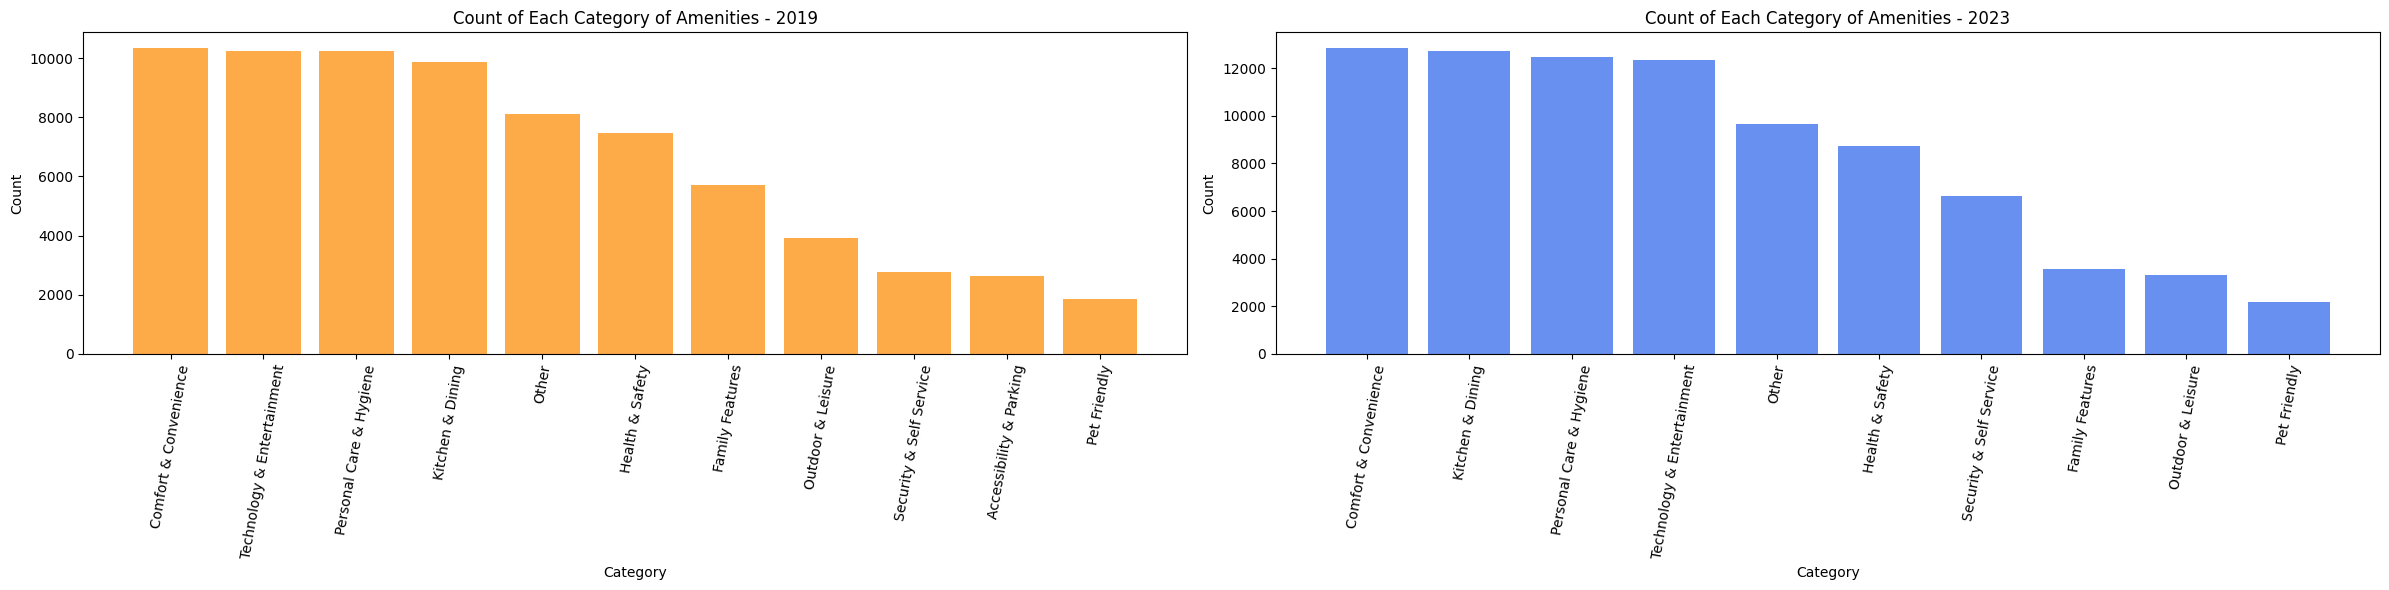

In [ ]:
# Convert the category counts for 2019 to a DataFrame
category_df_2019 = pd.DataFrame(category_counts_2019.items(), columns=['Category', 'Count'])
category_df_2019 = category_df_2019.sort_values(by='Count', ascending=False)

# Convert the category counts for 2023 to a DataFrame
category_df_2023 = pd.DataFrame(category_counts_2023.items(), columns=['Category', 'Count'])
category_df_2023 = category_df_2023.sort_values(by='Count', ascending=False)

plt.figure(figsize=(24, 6))

# Subplot for 2019
plt.subplot(1, 2, 1)
plt.bar(category_df_2019['Category'], category_df_2019['Count'], color='#fdaa48')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category of Amenities - 2019')
plt.xticks(rotation=80)

# Subplot for 2023
plt.subplot(1, 2, 2)
plt.bar(category_df_2023['Category'], category_df_2023['Count'], color='#6890F0')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category of Amenities - 2023')
plt.xticks(rotation=80)

plt.tight_layout()
plt.show()

### **Question 1.12:** Average price per neighborhood

In [ ]:
# Calculating average prices for each neighborhood accommodating two people
unique_listings_2019['average_price'] = unique_listings_2019[['price_april', 'price_february', 'price_march']].mean(axis=1)
filtered_2019 = unique_listings_2019[unique_listings_2019['accommodates'] == 2]
average_price_per_neighborhood_2019 = filtered_2019.groupby('neighbourhood_cleansed')['average_price'].mean().reset_index()

unique_listings_2023['average_price'] = unique_listings_2023[['price_june', 'price_september', 'price_march']].mean(axis=1)
filtered_2023 = unique_listings_2023[unique_listings_2023['accommodates'] == 2]
average_price_per_neighborhood_2023 = filtered_2023.groupby('neighbourhood')['average_price'].mean().reset_index()

average_price_per_neighborhood_2019.rename(columns={'neighbourhood_cleansed': 'Neighborhood', 'average_price': 'Average Price 2019'}, inplace=True)
average_price_per_neighborhood_2023.rename(columns={'neighbourhood': 'Neighborhood', 'average_price': 'Average Price 2023'}, inplace=True)

# Merge the dataframes on Neighborhood
combined_prices = pd.merge(average_price_per_neighborhood_2019, average_price_per_neighborhood_2023, on='Neighborhood', how='outer')

print("Average Prices per Neighborhood for Listings Accommodating Two People:")
display(combined_prices)

Average Prices per Neighborhood for Listings Accommodating Two People:


Neighborhood  Average Price 2019  Average Price 2023
0                     1Ο ΝΕΚΡΟΤΑΦΕΙΟ           36.893876           82.159201
1                   ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ           26.181822           60.158144
2   ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ           40.463062           68.138826
3                     ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ           30.382312           58.480985
4                  ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ           45.422271           65.554807
5                           ΑΚΡΟΠΟΛΗ           49.008156           85.696172
6                        ΑΜΠΕΛΟΚΗΠΟΙ           37.446134           57.223056
7                         ΑΝΩ ΚΥΨΕΛΗ           28.252640           42.463587
8                        ΑΝΩ ΠΑΤΗΣΙΑ           37.025394           45.731341
9                          ΒΟΤΑΝΙΚΟΣ           39.223489           58.984837
10                             ΓΚΑΖΙ           43.845388           75.483643
11                             ΓΚΥΖΗ           31.807707           48.794395
12                             ΓΟΥΒΑ           29.795703           56.316327
13                             ΓΟΥΔΙ           41.385653           64.649624
14                       ΕΛΛΗΝΟΡΩΣΩΝ           51.937814          102.764728
15            ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ           68.570104           98.202222
16                           ΖΑΠΠΕΙΟ           50.256779          192.568266
17                            ΘΗΣΕΙΟ           53.155185           99.545802
18                            ΙΛΙΣΙΑ           42.480676           77.065711
19                        ΚΕΡΑΜΕΙΚΟΣ           55.412909           80.277881
20                        ΚΟΛΟΚΥΝΘΟΥ           33.399722           45.200000
21                          ΚΟΛΩΝΑΚΙ           53.518317           95.219192
22                           ΚΟΛΩΝΟΣ           33.593496           48.442791
23               ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ           42.505376           82.723551
24                            ΚΥΨΕΛΗ           32.156968           48.884209
25                        ΛΥΚΑΒΗΤΤΟΣ           51.426848           86.278311
26          ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ           39.304599           75.606904
27                        ΝΕΑ ΚΥΨΕΛΗ           25.692308           48.502329
28                       ΝΕΟΣ ΚΟΣΜΟΣ           45.531735           72.112679
29                           ΝΙΡΒΑΝΑ           28.933954           46.624748
30                          ΠΑΓΚΡΑΤΙ           36.678727           67.243100
31                           ΠΑΤΗΣΙΑ           32.224883           48.627923
32                       ΠΕΔΙΟ ΑΡΕΩΣ           32.088693           52.805768
33                         ΠΕΝΤΑΓΩΝΟ           44.232061                 NaN
34                         ΠΕΤΡΑΛΩΝΑ           35.681571           60.452766
35                  ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ           29.801650           47.051789
36                   ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ           30.365233           53.025286
37                          ΠΟΛΥΓΩΝΟ           27.217212           53.163566
38                          ΠΡΟΜΠΟΝΑ           17.000000           47.765507
39                          ΡΗΓΙΛΛΗΣ           56.333333           96.227915
40                         ΡΙΖΟΥΠΟΛΗ           32.474682           48.055556
41                           ΣΕΠΟΛΙΑ           24.066303           57.339063
42                            ΣΤΑΔΙΟ           41.873062           69.859034
43                   ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ           36.722349           51.187867

/tmp/ipython-input-2725570614.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_2019, x='Average Price 2019', y='Neighborhood', ax=axes[0], palette='Blues_d')
/tmp/ipython-input-2725570614.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_2023, x='Average Price 2023', y='Neighborhood', ax=axes[1], palette='Greens_d')


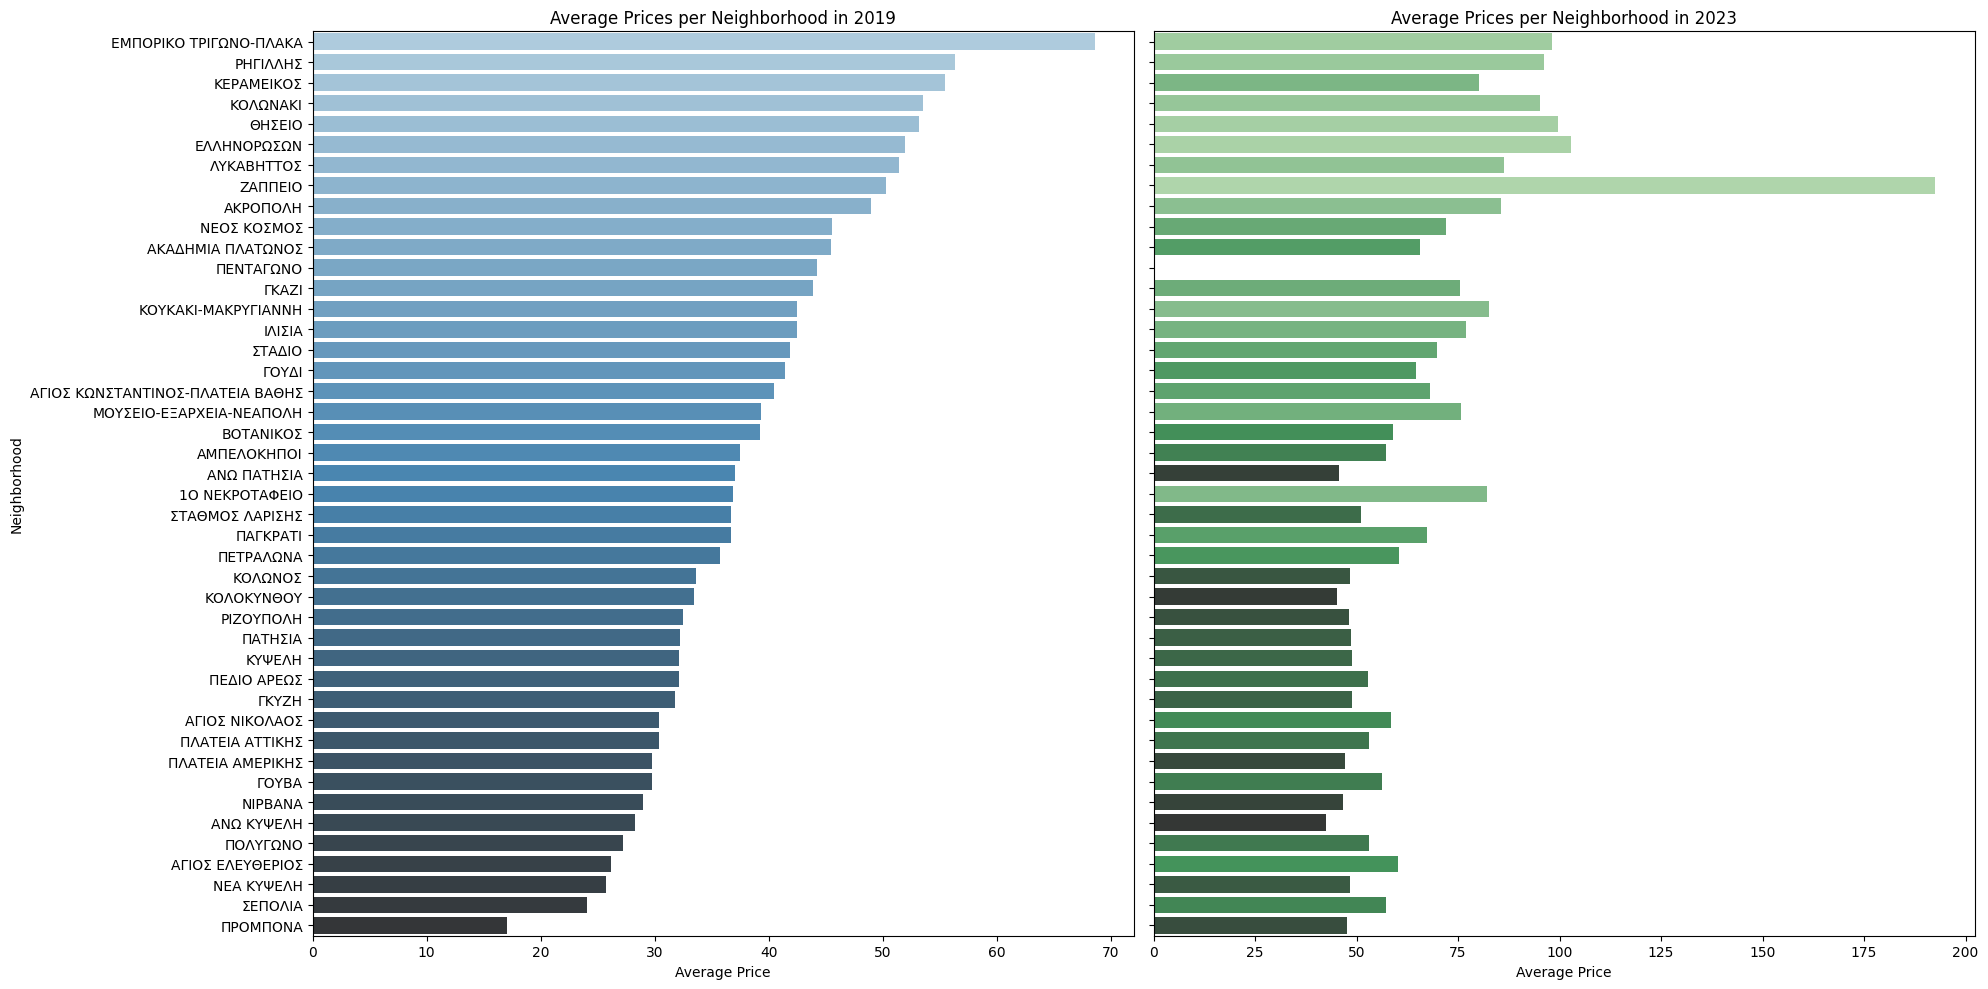

In [ ]:
# Sort the data for each year by average price
sorted_2019 = average_price_per_neighborhood_2019.sort_values(by='Average Price 2019', ascending=False)
sorted_2023 = average_price_per_neighborhood_2023.sort_values(by='Average Price 2023', ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)

# Plot for 2019
sns.barplot(data=sorted_2019, x='Average Price 2019', y='Neighborhood', ax=axes[0], palette='Blues_d')
axes[0].set_title('Average Prices per Neighborhood in 2019')
axes[0].set_xlabel('Average Price')
axes[0].set_ylabel('Neighborhood')

# Plot for 2023
sns.barplot(data=sorted_2023, x='Average Price 2023', y='Neighborhood', ax=axes[1], palette='Greens_d')
axes[1].set_title('Average Prices per Neighborhood in 2023')
axes[1].set_xlabel('Average Price')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

 We classified the neighborhoods into 3 groups (very
expensive, moderate, affordable) depending on the average price of the rooms. To do this, we used the quantile() method. We used the 33rd and 66th percentiles to divide the neighborhoods into three roughly equal groups.

In [ ]:
# Helper function to categorize neighborhoods based on price thresholds
def categorize_price(price, thresholds):
    if price <= thresholds[0]:
        return 'Affordable'
    elif price <= thresholds[1]:
        return 'Moderate'
    else:
        return 'Very Expensive'

def apply_categorization(dataframe, price_column):
    # Calculate quantiles for the given price column
    thresholds = dataframe[price_column].quantile([0.33, 0.66]).values
    # Categorize prices using the calculated thresholds
    dataframe['Category'] = dataframe[price_column].apply(categorize_price, thresholds=thresholds)
    return dataframe

# Calculate and categorize average prices for 2019
average_price_per_neighborhood_2019 = apply_categorization(average_price_per_neighborhood_2019, 'Average Price 2019')

# Calculate and categorize average prices for 2023
average_price_per_neighborhood_2023 = apply_categorization(average_price_per_neighborhood_2023, 'Average Price 2023')

# Merge the categorized dataframes on Neighborhood and include the categories
combined_prices = pd.merge(
    average_price_per_neighborhood_2019[['Neighborhood', 'Average Price 2019', 'Category']],
    average_price_per_neighborhood_2023[['Neighborhood', 'Average Price 2023', 'Category']],
    on='Neighborhood', how='outer', suffixes=(' 2019', ' 2023')
)

In [ ]:
combined_prices.rename(columns={
    'Category_x': 'Category 2019',
    'Category_y': 'Category 2023',
    'Average Price 2019': 'Avg Price 2019',
    'Average Price 2023': 'Avg Price 2023'
}, inplace=True)

combined_prices.sort_values(by='Avg Price 2019', ascending=False, inplace=True)

print("Average Prices and Categories per Neighborhood for Listings Accommodating Two People:")
display(combined_prices)

Average Prices and Categories per Neighborhood for Listings Accommodating Two People:


Neighborhood  Avg Price 2019   Category 2019  \
15            ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ       68.570104  Very Expensive   
39                          ΡΗΓΙΛΛΗΣ       56.333333  Very Expensive   
19                        ΚΕΡΑΜΕΙΚΟΣ       55.412909  Very Expensive   
21                          ΚΟΛΩΝΑΚΙ       53.518317  Very Expensive   
17                            ΘΗΣΕΙΟ       53.155185  Very Expensive   
14                       ΕΛΛΗΝΟΡΩΣΩΝ       51.937814  Very Expensive   
25                        ΛΥΚΑΒΗΤΤΟΣ       51.426848  Very Expensive   
16                           ΖΑΠΠΕΙΟ       50.256779  Very Expensive   
5                           ΑΚΡΟΠΟΛΗ       49.008156  Very Expensive   
28                       ΝΕΟΣ ΚΟΣΜΟΣ       45.531735  Very Expensive   
4                  ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ       45.422271  Very Expensive   
33                         ΠΕΝΤΑΓΩΝΟ       44.232061  Very Expensive   
10                             ΓΚΑΖΙ       43.845388  Very Expensive   
23               ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ       42.505376  Very Expensive   
18                            ΙΛΙΣΙΑ       42.480676  Very Expensive   
42                            ΣΤΑΔΙΟ       41.873062        Moderate   
13                             ΓΟΥΔΙ       41.385653        Moderate   
2   ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ       40.463062        Moderate   
26          ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ       39.304599        Moderate   
9                          ΒΟΤΑΝΙΚΟΣ       39.223489        Moderate   
6                        ΑΜΠΕΛΟΚΗΠΟΙ       37.446134        Moderate   
8                        ΑΝΩ ΠΑΤΗΣΙΑ       37.025394        Moderate   
0                     1Ο ΝΕΚΡΟΤΑΦΕΙΟ       36.893876        Moderate   
43                   ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ       36.722349        Moderate   
30                          ΠΑΓΚΡΑΤΙ       36.678727        Moderate   
34                         ΠΕΤΡΑΛΩΝΑ       35.681571        Moderate   
22                           ΚΟΛΩΝΟΣ       33.593496        Moderate   
20                        ΚΟΛΟΚΥΝΘΟΥ       33.399722        Moderate   
40                         ΡΙΖΟΥΠΟΛΗ       32.474682        Moderate   
31                           ΠΑΤΗΣΙΑ       32.224883      Affordable   
24                            ΚΥΨΕΛΗ       32.156968      Affordable   
32                       ΠΕΔΙΟ ΑΡΕΩΣ       32.088693      Affordable   
11                             ΓΚΥΖΗ       31.807707      Affordable   
3                     ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ       30.382312      Affordable   
36                   ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ       30.365233      Affordable   
35                  ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ       29.801650      Affordable   
12                             ΓΟΥΒΑ       29.795703      Affordable   
29                           ΝΙΡΒΑΝΑ       28.933954      Affordable   
7                         ΑΝΩ ΚΥΨΕΛΗ       28.252640      Affordable   
37                          ΠΟΛΥΓΩΝΟ       27.217212      Affordable   
1                   ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ       26.181822      Affordable   
27                        ΝΕΑ ΚΥΨΕΛΗ       25.692308      Affordable   
41                           ΣΕΠΟΛΙΑ       24.066303      Affordable   
38                          ΠΡΟΜΠΟΝΑ       17.000000      Affordable   

    Avg Price 2023   Category 2023  
15       98.202222  Very Expensive  
39       96.227915  Very Expensive  
19       80.277881  Very Expensive  
21       95.219192  Very Expensive  
17       99.545802  Very Expensive  
14      102.764728  Very Expensive  
25       86.278311  Very Expensive  
16      192.568266  Very Expensive  
5        85.696172  Very Expensive  
28       72.112679  Very Expensive  
4        65.554807        Moderate  
33             NaN             NaN  
10       75.483643  Very Expensive  
23       82.723551  Very Expensive  
18       77.065711  Very Expensive  
42       69.859034        Moderate  
13       64.649624        Moderate  
2        68.138826        Moderate  
26       75.606904  Very Expensive  
9        58.984837        Moderate  
6     

### **Question 1.13:**

#### **Question 1.13.1:** Relationship Between Review Scores and Pricing

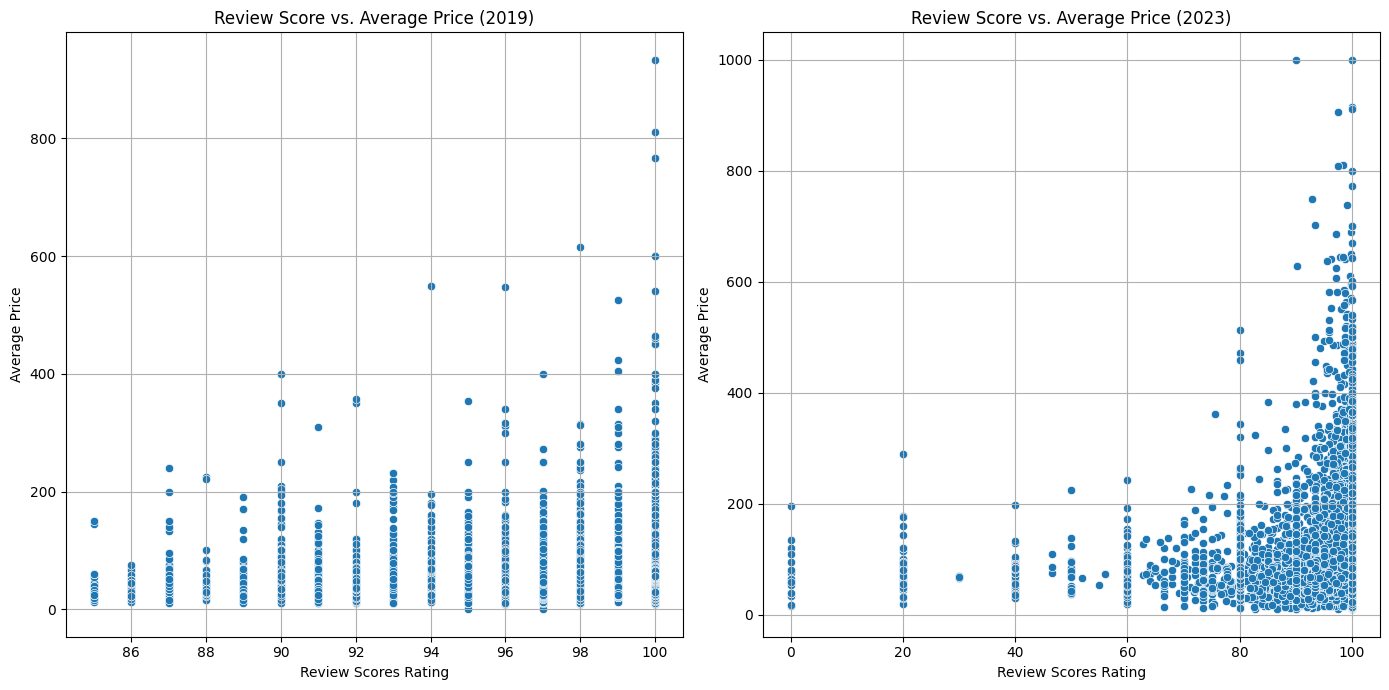

In [ ]:
# Scatter Plot for 2019
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='review_scores_rating', y='average_price', data=unique_listings_2019)
plt.title('Review Score vs. Average Price (2019)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Average Price')
plt.grid(True)

# Scatter Plot for 2023
plt.subplot(1, 2, 2)
sns.scatterplot(x='review_scores_rating', y='average_price', data=unique_listings_2023)
plt.title('Review Score vs. Average Price (2023)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Average Price')
plt.grid(True)

plt.tight_layout()
plt.show()

#### **Question 1.13.2:** Relationship between house listing prices and their distance from the Acropolis of Athens

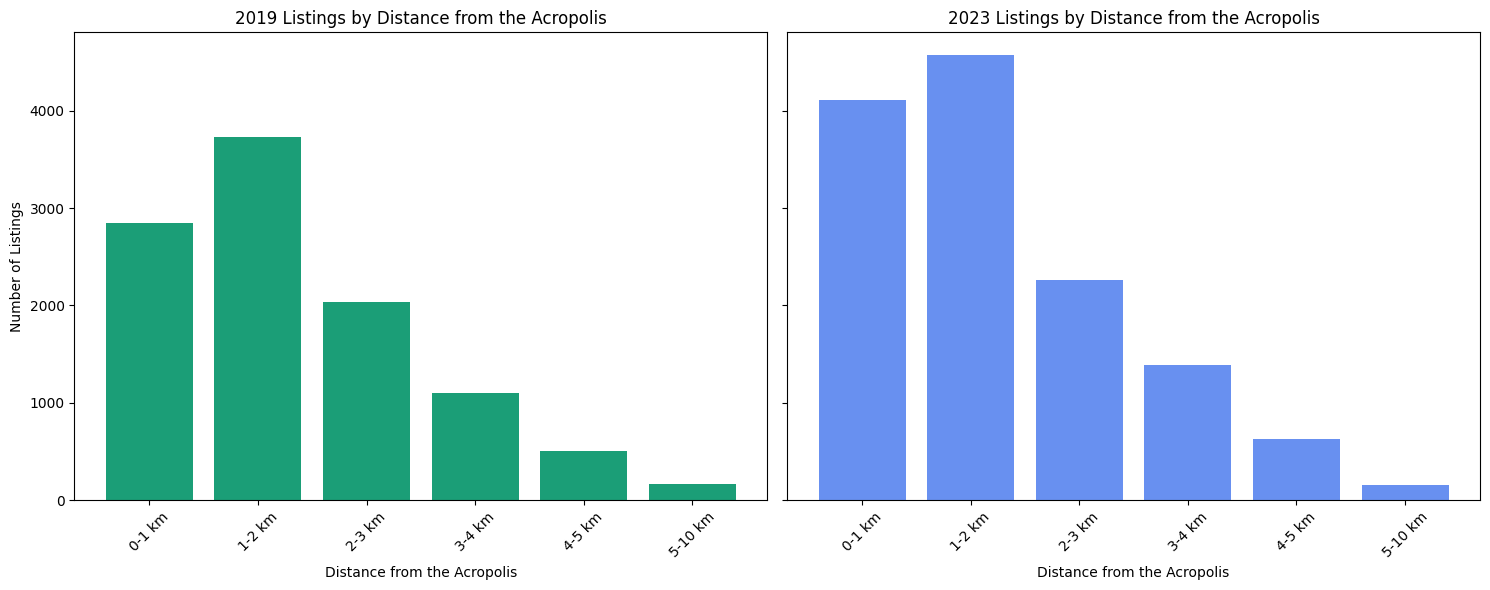

In [ ]:
# Function to calculate Euclidean distance
def euclidean_distance(lat1, lon1, lat2, lon2):
    # Conversion factor to convert degrees to kilometers
    lat_to_km = 111.32  # kilometers per degree of latitude
    lon_to_km = 111.32 * np.cos(np.radians(lat1))  # kilometers per degree of longitude

    delta_lat = (lat2 - lat1) * lat_to_km
    delta_lon = (lon2 - lon1) * lon_to_km

    return np.sqrt(delta_lat**2 + delta_lon**2)

# Acropolis coordinates
acropolis_lat, acropolis_lon = 37.9715, 23.7257

# Calculate distances from Acropolis for each listing
unique_listings_2019['distance_from_acropolis'] = unique_listings_2019.apply(
    lambda row: euclidean_distance(acropolis_lat, acropolis_lon, row['latitude'], row['longitude']),
    axis=1
)

unique_listings_2023['distance_from_acropolis'] = unique_listings_2023.apply(
    lambda row: euclidean_distance(acropolis_lat, acropolis_lon, row['latitude'], row['longitude']),
    axis=1
)

# Categorize distances
bins = [0, 1, 2, 3, 4, 5, 10]
labels = ['0-1 km', '1-2 km', '2-3 km', '3-4 km', '4-5 km', '5-10 km']
unique_listings_2019['distance_category'] = pd.cut(unique_listings_2019['distance_from_acropolis'], bins=bins, labels=labels, right=False)
unique_listings_2023['distance_category'] = pd.cut(unique_listings_2023['distance_from_acropolis'], bins=bins, labels=labels, right=False)

# Count listings in each distance category
distance_counts_2019 = unique_listings_2019['distance_category'].value_counts().sort_index()
distance_counts_2023 = unique_listings_2023['distance_category'].value_counts().sort_index()

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# 2019 data
distance_counts_2019 = unique_listings_2019['distance_category'].value_counts().sort_index()
axes[0].bar(distance_counts_2019.index, distance_counts_2019, color='#1b9e77')
axes[0].set_title('2019 Listings by Distance from the Acropolis')
axes[0].set_xlabel('Distance from the Acropolis')
axes[0].set_ylabel('Number of Listings')
axes[0].tick_params(axis='x', rotation=45)

# 2023 data
distance_counts_2023 = unique_listings_2023['distance_category'].value_counts().sort_index()
axes[1].bar(distance_counts_2023.index, distance_counts_2023, color='#6890F0')
axes[1].set_title('2023 Listings by Distance from the Acropolis')
axes[1].set_xlabel('Distance from the Acropolis')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### **Question 1.13.3:** Most friendly neighborhood in Athens - Neighborhood with the most pet friendly listings

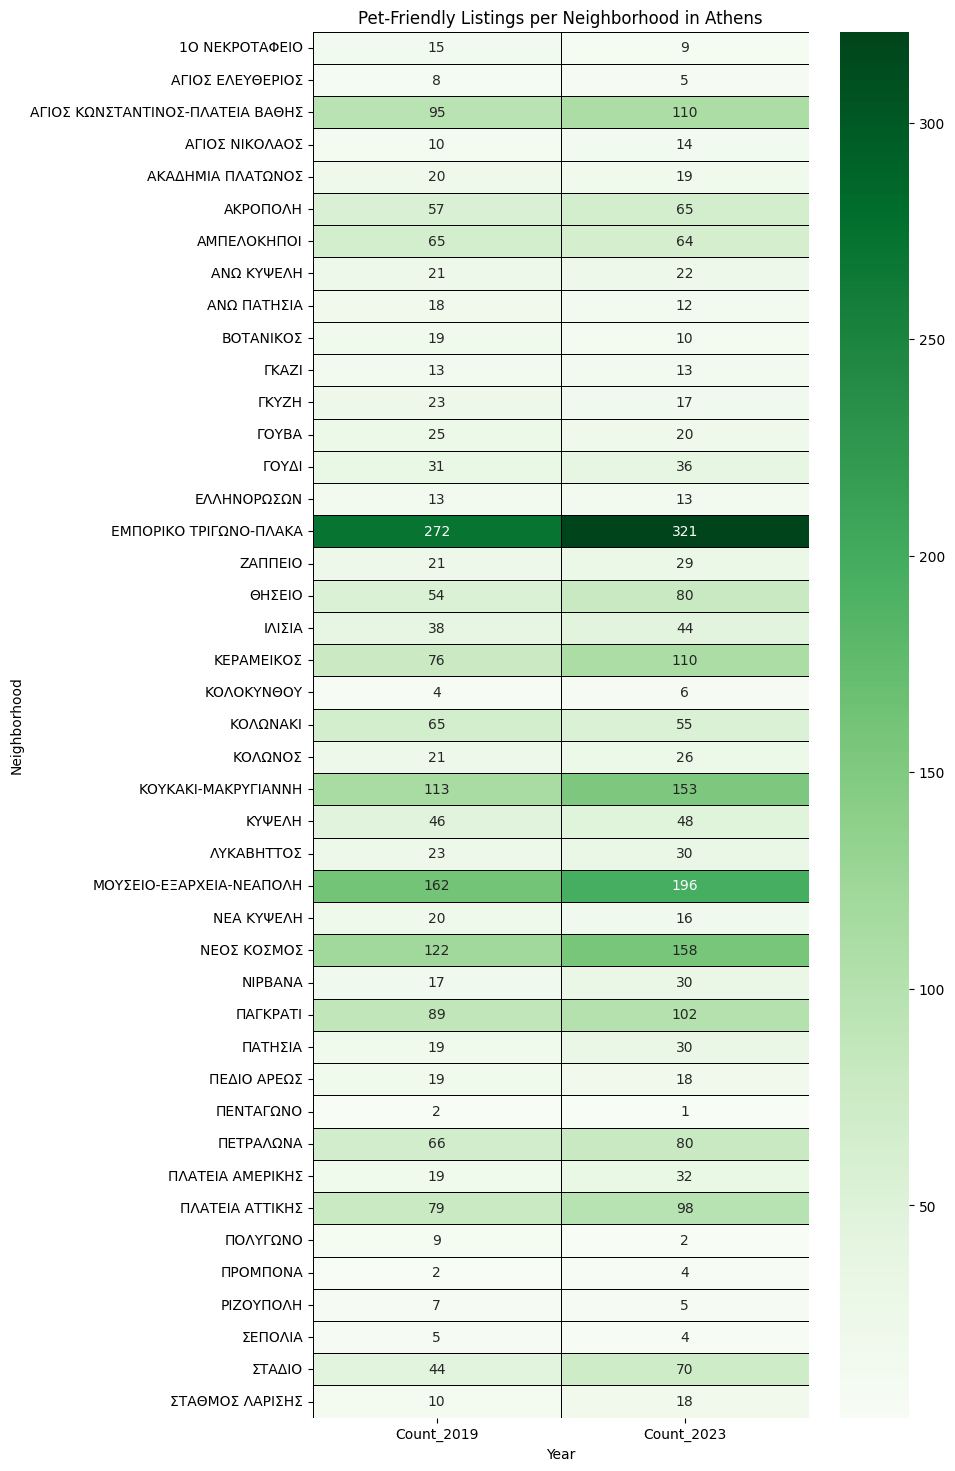

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to count pet-friendly listings per neighborhood
def count_pet_friendly_listings(data):
    # Filter listings that are categorized as 'Pet Friendly'
    pet_friendly = data[data['amenities'].str.contains('Pet Friendly')]
    # Count listings per neighborhood
    counts = pet_friendly['neighbourhood_cleansed'].value_counts().reset_index()
    counts.columns = ['Neighborhood', 'Count']
    return counts

# Count pet-friendly listings for each year
pet_friendly_counts_2019 = count_pet_friendly_listings(unique_listings_2019)
pet_friendly_counts_2023 = count_pet_friendly_listings(unique_listings_2023)

combined_counts = pet_friendly_counts_2019.merge(pet_friendly_counts_2023, on='Neighborhood', suffixes=('_2019', '_2023'))

# Use melt to create a proper DataFrame for the heatmap
heatmap_data = combined_counts.melt(id_vars=['Neighborhood'], value_vars=['Count_2019', 'Count_2023'], var_name='Year', value_name='Count')

# Pivot the melted DataFrame for the heatmap
heatmap_data = heatmap_data.pivot(index='Neighborhood', columns='Year', values='Count')

# Plot
plt.figure(figsize=(8, 18))
sns.heatmap(heatmap_data, cmap='Greens', annot=True, fmt='d', linewidths=.5, linecolor='black')
plt.title('Pet-Friendly Listings per Neighborhood in Athens')
plt.xlabel('Year')
plt.ylabel('Neighborhood')
plt.show()

### **Question 1.14:** 10 hosts with the most listings

In [ ]:
from tabulate import tabulate

host_listings_count = unique_listings_2019.groupby('host_id').size().reset_index(name='num_host_listings_2019')
top_10_hosts = host_listings_count.nlargest(10, 'num_host_listings_2019')

data = top_10_hosts.values.tolist()

# Get the column names
headers = top_10_hosts.columns.tolist()

# Display the tabulated data
print(tabulate(data, headers=headers, tablefmt='fancy_grid'))

host_listings_count = unique_listings_2023.groupby('host_id').size().reset_index(name='num_host_listings_2023')
top_10_hosts = host_listings_count.nlargest(10, 'num_host_listings_2023')

data = top_10_hosts.values.tolist()

# Get the column names
headers = top_10_hosts.columns.tolist()

print(tabulate(data, headers=headers, tablefmt='fancy_grid'))

╒═══════════╤══════════════════════════╕
│   host_id │   num_host_listings_2019 │
╞═══════════╪══════════════════════════╡
│  77457889 │                      126 │
├───────────┼──────────────────────────┤
│  29927830 │                       96 │
├───────────┼──────────────────────────┤
│ 135482892 │                       86 │
├───────────┼──────────────────────────┤
│    748818 │                       80 │
├───────────┼──────────────────────────┤
│   1621474 │                       72 │
├───────────┼──────────────────────────┤
│   1418201 │                       63 │
├───────────┼──────────────────────────┤
│ 112527018 │                       57 │
├───────────┼──────────────────────────┤
│  65714690 │                       48 │
├───────────┼──────────────────────────┤
│   2718115 │                       46 │
├───────────┼──────────────────────────┤
│   2089542 │                       45 │
╘═══════════╧══════════════════════════╛
╒═══════════╤══════════════════════════╕
│   host_id │   

### **Question 1.15:** Conclusion 💭


*   The graph from question 1.2 illustrates a clear trend in the average price of listings, with a noticeable increase from 2019 to 2023. March, the only month present in both datasets, shows a rise of $20 in average price. In 2019, prices remained consistent across February, March, and April, which typically represent the off-season months. In contrast, the 2023 data from June and September, months of the summer season, shows prices steadily rising.

*  The graph from question 1.6 clearly illustrates a significant increase in the number of listings from 2019 to 2023. Most listings are concentrated in the same popular neighborhoods across both years. The top five neighborhoods with the highest number of listings in both 2019 and 2023 are 'ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ - ΠΛΑΚΑ', 'ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ', 'ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ', 'ΝΕΟΣ ΚΟΣΜΟΣ' and 'ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ'.

*   **Most Expensive Room Type:** Across both 2019 and 2023, the "Entire home/apt" category consistently ranks as the most expensive room type, likely due to its larger size. The "hotel room" category was introduced in 2023 but despite this addition, it did not surpass the "
Entire home/apt" in terms of price.

* The majority of listings are concentrated within 2 km of the Acropolis, making central Athens a key area for accommodations. The 2023 data shows an increase in listings, particularly noticeable in the 1-2 km range from the Acropolis. This suggests a growing preference for locations slightly further from the immediate center yet still within close proximity.


## **Question 2:** Recommendation System

#### 1️⃣ **TF-IDF:** 10 Most Frequently Used Words by Visitors in Athens

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# Create a new column by concatenating 'name' and 'description' columns
unique_listings_2019['concatenated_text'] = (unique_listings_2019['name'].fillna('') + ' ' +
                                             unique_listings_2019['description'].fillna(''))

# Convert ENGLISH_STOP_WORDS to a list
stop_words_list = list(ENGLISH_STOP_WORDS)

# Initialize TfidfVectorizer to include both unigrams and bigrams
tfidf = TfidfVectorizer(max_features=20,
                        strip_accents='unicode', analyzer='word',
                        stop_words=stop_words_list, lowercase=True,
                        use_idf=True, ngram_range=(1, 2))

# Fit and transform the text data to generate TF-IDF matrix that includes both unigrams and bigrams
X = tfidf.fit_transform(unique_listings_2019['concatenated_text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
print("TF-IDF Matrix with Unigrams and Bigrams:")
print(tfidf_df)

TF-IDF Matrix with Unigrams and Bigrams:
       acropolis  apartment      area    athens  bathroom       bed   bedroom  \
0       0.000000   0.425212  0.000000  0.161073  0.000000  0.241334  0.647975   
1       0.000000   0.556120  0.000000  0.210662  0.161128  0.157816  0.338985   
2       0.000000   0.513562  0.000000  0.194541  0.148798  0.145739  0.313044   
3       0.000000   0.000000  0.000000  0.000000  0.278012  0.000000  0.000000   
4       0.000000   0.239305  0.000000  0.000000  0.173339  0.169775  0.364673   
...          ...        ...       ...       ...       ...       ...       ...   
10380   0.000000   0.000000  0.535691  0.844414  0.000000  0.000000  0.000000   
10381   0.000000   0.606492  0.000000  0.382906  0.000000  0.000000  0.308075   
10382   0.434191   0.000000  0.000000  0.749416  0.000000  0.000000  0.000000   
10383   0.000000   0.000000  0.621341  0.783540  0.000000  0.000000  0.000000   
10384   0.000000   1.000000  0.000000  0.000000  0.000000  0.000000 

#### 2️⃣ **Cosine Similarity:** 100 most similar properties

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(X)

# Store 100 most similar listings for each listing
top_similarities = {}

# Number of top items to keep
top_n = 100

for idx in range(cosine_sim_matrix.shape[0]):
    # Get pairwise similarities for listing 'idx'
    similarity_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort listings based on the similarity scores
    sorted_similarities = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Skip first entry (since it is the item itself) and store the top 100 similar properties
    top_similarities[idx] = sorted_similarities[1:top_n + 1]

# Most similar items to the first listing
for similarity in top_similarities[0]:
    print(f'Listing Index: {similarity[0]}, Similarity Score: {similarity[1]:.4f}')

Listing Index: 2188, Similarity Score: 0.8966
Listing Index: 10208, Similarity Score: 0.8959
Listing Index: 1, Similarity Score: 0.8956
Listing Index: 1706, Similarity Score: 0.8946
Listing Index: 3112, Similarity Score: 0.8864
Listing Index: 9713, Similarity Score: 0.8864
Listing Index: 2, Similarity Score: 0.8825
Listing Index: 5220, Similarity Score: 0.8704
Listing Index: 6113, Similarity Score: 0.8702
Listing Index: 2641, Similarity Score: 0.8699
Listing Index: 7134, Similarity Score: 0.8640
Listing Index: 7832, Similarity Score: 0.8624
Listing Index: 10117, Similarity Score: 0.8610
Listing Index: 5249, Similarity Score: 0.8583
Listing Index: 7660, Similarity Score: 0.8576
Listing Index: 1103, Similarity Score: 0.8575
Listing Index: 2257, Similarity Score: 0.8575
Listing Index: 1211, Similarity Score: 0.8575
Listing Index: 9182, Similarity Score: 0.8573
Listing Index: 4473, Similarity Score: 0.8565
Listing Index: 5179, Similarity Score: 0.8554
Listing Index: 6882, Similarity Score:

#### 3️⃣ **Function that returns N more similar listings**

In [ ]:
def recommend(item_id, num):
  index = item_id

  # Get the top num similar items
  if index in top_similarities:
      similar_items = top_similarities[index][:num]
  else:
      return f"No recommendations found for item ID {item_id}"

  # Print header
  print(f"Recommending {num} listings similar to {unique_listings_2019.loc[index, 'name']}")
  print("---------------------------------------------------------")

  # Print details for each recommended item
  for sim_index, score in similar_items:
      # Get name and description
      name = unique_listings_2019.loc[sim_index, 'name']
      description = unique_listings_2019.loc[sim_index, 'description']

      # Print details
      print(f"Recommended: {name}")
      print(f"Description: {description}")
      print(f"(score: {score})\n********")

recommend(item_id=2188, num=5)

Recommending 5 listings similar to Spacious 2BR in The Center of Athens!
---------------------------------------------------------
Recommended: Lovely 1 bedroom apartment in Athens
Description: The apartment, which was renovated on December 2018, is close to public transport (next to metro station Aghios Ioannis) and the city center. You will love the apt because of the neighborhood, the bright bedroom and the comfy Queen bed. My place is ideal for couples, solo adventurers, business travelers, and families. The Bedroom has a Queen bed, a closet, hair dryer, clothes iron. The Living Room has a comfortable Sofa, a single bed and a Flat TV, while the Kitchen is equipped with a stove, refrigerator, microwave, coffee maker and all kitchenware needed to prepare a nice home cooked meal for your friends and family. The bathroom is nicely lit, clean, with a bathtub. The whole apartment is fully air conditioned while there is also a boiler to provide you with hot water for 24/7. Of course the b

#### 4️⃣ **BigramCollocationFinder: 10 words that tend to appear together often**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# Tokenize the concatenated text
words = word_tokenize(' '.join(unique_listings_2019['concatenated_text']))

# Remove punctuation
words = [word for word in words if word not in string.punctuation]

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Initialize a BigramCollocationFinder
bigram_finder = BigramCollocationFinder.from_words(filtered_words)

# Score the bigrams using frequency
bigram_scored = bigram_finder.score_ngrams(BigramAssocMeasures.raw_freq)

# Get the top 10 frequent bigrams
top_10_bigrams = bigram_scored[:10]

# Print the top 10 frequent bigrams
print("Top 10 Frequent Bigrams:")
for bigram, score in top_10_bigrams:
    print(bigram)

Top 10 Frequent Bigrams:
('living', 'room')
('fully', 'equipped')
('metro', 'station')
('double', 'bed')
('walking', 'distance')
('center', 'Athens')
('heart', 'Athens')
('equipped', 'kitchen')
('apartment', 'located')
('minutes', 'walk')
